# Importation des librairies

In [5]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import os.path

from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sksurv.ensemble import RandomSurvivalForest
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored , concordance_index_ipcw
from sklearn.impute import SimpleImputer
from sksurv.util import Surv
from lifelines.utils import concordance_index



# Preprocessing

In [6]:
clinical_test=pd.read_csv('data/clinical_test.csv')
clinical_train=pd.read_csv('data/clinical_train.csv')

molecular_test=pd.read_csv('data/molecular_test.csv')
molecular_train=pd.read_csv('data/molecular_train.csv')


In [7]:
target_df=pd.read_csv('data/target_train.csv')

# Drop rows where 'OS_YEARS' is NaN if conversion caused any issues
target_df.dropna(subset=['OS_YEARS', 'OS_STATUS'], inplace=True)


# Contarget_dfvert 'OS_YEARS' to numeric if it isn’t already
target_df['OS_YEARS'] = pd.to_numeric(target_df['OS_YEARS'], errors='coerce')

# Ensure 'OS_STATUS' is boolean
target_df['OS_STATUS'] = target_df['OS_STATUS'].astype(bool)

In [8]:
from sklearn.impute import KNNImputer

def precise_missing_values(df):
    # Imputation KNN pour les variables numériques
    num_cols = df.select_dtypes(include=['float64', 'int64']).columns
    imputer = KNNImputer(n_neighbors=5)
    df[num_cols] = imputer.fit_transform(df[num_cols])

    # Pour les variables catégorielles, on remplace par 'Missing'
    cat_cols = df.select_dtypes(include=['object']).columns
    for col in cat_cols:
        df[col] = df[col].fillna('Missing')
    return df

clinical_train = precise_missing_values(clinical_train)
clinical_test = precise_missing_values(clinical_test)
molecular_train = precise_missing_values(molecular_train)
molecular_test = precise_missing_values(molecular_test)

In [9]:
import pandas as pd
import numpy as np

def aggregate_leukemia_data_improved(df, clinical_df=None):
    """
    Agrégation avancée des données de mutations par patient avec intégration
    des facteurs pronostiques ELN 2022 et des recommandations cliniques.
    (Version sans intégration des données cliniques)
    """
    # === DÉFINITIONS DES GÈNES SELON ELN 2022 ===
    adverse_genes = {
        'TP53', 'ASXL1', 'RUNX1', 'EZH2', 'SF3B1', 'SRSF2', 'U2AF1', 
        'ZRSR2', 'STAG2', 'BCOR', 'SETBP1'
    }
    dna_methylation_genes = {'DNMT3A', 'TET2', 'IDH1', 'IDH2'}
    favorable_genes = {'NPM1', 'CEBPA'}
    all_genes = [
        'GNB1', 'CSF3R', 'MPL', 'NRAS', 'HAX1', 'RIT1', 'SMC3', 'WT1', 'ATM', 'CBL',
        'ETV6', 'ETNK1', 'KRAS', 'ARID2', 'NFE2', 'SH2B3', 'PTPN11', 'FLT3', 'BRCA2',
        'PDS5B', 'IDH2', 'BLM', 'CREBBP', 'CTCF', 'PRPF8', 'TP53', 'NF1', 'SUZ12',
        'STAT5B', 'STAT3', 'PPM1D', 'SRSF2', 'SETBP1', 'BCL2', 'EPOR', 'CALR', 'CEBPA',
        'U2AF2', 'DNMT3A', 'ASXL2', 'SF3B1', 'IDH1', 'ASXL1', 'GNAS', 'RUNX1', 'U2AF1',
        'CHEK2', 'MYD88', 'GATA2', 'KIT', 'TET2', 'TERT', 'IRF1', 'CSNK1A1', 'NPM1',
        'NSD1', 'DDX41', 'JARID2', 'CCND3', 'VEGFA', 'IKZF1', 'EGFR', 'SBDS', 'CUX1',
        'BRAF', 'EZH2', 'RAD21', 'JAK2', 'CDKN2A', 'FANCG', 'NOTCH1', 'PIGA', 'ZRSR2',
        'BCOR', 'USP9X', 'KDM6A', 'SMC1A', 'MED12', 'STAG2', 'BCORL1', 'PHF6', 'BRCC3',
        'MLL'
    ]
    gene_weights = {
        'TP53': 5.0,
        'ASXL1': 2.0, 'RUNX1': 2.0, 'EZH2': 2.0,
        'SF3B1': 1.8, 'SRSF2': 1.8, 'U2AF1': 1.8, 'ZRSR2': 1.8,
        'STAG2': 1.5, 'BCOR': 1.5, 'SETBP1': 1.5,
        'DNMT3A': 1.5, 'TET2': 1.5, 'IDH1': 1.8, 'IDH2': 1.8,
        'FLT3': 2.0,
        'NPM1': -2.5,
        'CEBPA': -3.0,
        'KIT': 1.2, 'NRAS': 0.8, 'KRAS': 0.8, 'PTPN11': 0.8
    }
    bad_effects = ['nonsense', 'frameshift', 'splice_site', 'stop_gained']
    # === AGRÉGATION BASIQUE ===
    result = df.groupby('ID').agg({
        'GENE': ['count', 'nunique'],
        'CHR': 'nunique',
        'VAF': ['mean', 'max', 'median', 'min', 'var'],
        'DEPTH': ['mean', 'median', 'min', 'max', 'var']
    }).reset_index()
    result.columns = [
        'ID', 'nb_mutations', 'nb_genes', 'nb_chromosomes',
        'vaf_mean', 'vaf_max', 'vaf_median', 'vaf_min', 'vaf_var',
        'depth_mean', 'depth_median', 'depth_min', 'depth_max', 'depth_var'
    ]
    # === MATRICE BINAIRE GÈNE x PATIENT ===
    has_gene = (
        df.pivot_table(index='ID', columns='GENE', values='CHR', aggfunc='size', fill_value=0)
        .reindex(columns=all_genes, fill_value=0)
        .astype(int)
    )
    has_gene.columns = [f'has_{g}' for g in has_gene.columns]
    has_gene.reset_index(inplace=True)
    result = result.merge(has_gene, on='ID', how='left')
    # === NOUVEAUX INDICATEURS GÉNÉTIQUES ===
    adverse_cols = [f'has_{g}' for g in adverse_genes if f'has_{g}' in result.columns]
    result['has_adverse_gene'] = result[adverse_cols].sum(axis=1).clip(upper=1)
    result['nb_adverse_genes'] = result[adverse_cols].sum(axis=1)
    methylation_cols = [f'has_{g}' for g in dna_methylation_genes if f'has_{g}' in result.columns]
    result['has_methylation_gene'] = result[methylation_cols].sum(axis=1).clip(upper=1)
    result['nb_methylation_genes'] = result[methylation_cols].sum(axis=1)
    result['has_NPM1_favorable'] = result.get('has_NPM1', 0)
    result['has_CEBPA_favorable'] = result.get('has_CEBPA', 0)
    result['high_mutation_burden'] = (result['nb_mutations'] > 3).astype(int)
    result['mutation_burden_score'] = np.where(
        result['nb_mutations'] > 3, 
        (result['nb_mutations'] - 3) * 0.5, 
        0
    )
    result['nb_bad_effects'] = df.groupby('ID')['EFFECT'].apply(lambda x: x.isin(bad_effects).sum()).values
    result['nb_high_vaf'] = df.groupby('ID')['VAF'].apply(lambda x: (x > 0.4).sum()).values
    result['nb_very_high_vaf'] = df.groupby('ID')['VAF'].apply(lambda x: (x > 0.6).sum()).values
    # === CALCUL DU SCORE DE RISQUE AMÉLIORÉ (SANS CLINIQUE) ===
    has_cols = [f'has_{g}' for g in gene_weights if f'has_{g}' in result.columns]
    weights_series = pd.Series([gene_weights[g] for g in gene_weights if f'has_{g}' in result.columns], 
                              index=has_cols)
    gene_score = result[has_cols].dot(weights_series)
    methylation_penalty = np.where(result['nb_methylation_genes'] >= 2, 
                                  result['nb_methylation_genes'] * 0.8, 0)
    npm1_modulation = 0
    if 'has_NPM1' in result.columns and 'has_FLT3' in result.columns:
        npm1_modulation = np.where(
            (result['has_NPM1'] == 1) & (result['has_FLT3'] == 1),
            1.5,
            0
        )
    result['risk_score_genetic'] = (
        gene_score +
        methylation_penalty +
        npm1_modulation +
        result['mutation_burden_score'] +
        0.3 * result['nb_high_vaf'] +
        0.5 * result['nb_very_high_vaf']
    )
    result['risk_score_raw'] = result['risk_score_genetic']
    def enhanced_logistic(score, intercept=3.0, scale=2.5, floor=0.05, ceiling=0.95):
        z = (score - intercept) / scale
        prob = 1.0 / (1.0 + np.exp(-z))
        return np.clip(prob, floor, ceiling)
    result['risk_score_prob'] = result['risk_score_raw'].apply(enhanced_logistic)
    def classify_eln_risk(row):
        if ((row.get('has_NPM1', 0) == 1 and row.get('has_FLT3', 0) == 0) or
            row.get('has_CEBPA', 0) == 1):
            if row['has_adverse_gene'] == 0:
                return 'Favorable'
        if (row['has_adverse_gene'] == 1 or 
            row.get('has_TP53', 0) == 1 or
            row['nb_adverse_genes'] >= 2):
            return 'Adverse'
        return 'Intermediate'
    result['eln_risk_category'] = result.apply(classify_eln_risk, axis=1)
    result['genetic_complexity'] = (
        result['nb_genes'] + 
        result['nb_adverse_genes'] * 2 + 
        result['nb_methylation_genes']
    )
    result['vaf_heterogeneity'] = result['vaf_var'].fillna(0)
    return result

# === FONCTION D'USAGE ===
def aggregation(molecular_train, molecular_test, clinical_train=None, clinical_test=None):
    print("Agrégation des données d'entraînement...")
    molecular_train_agg = aggregate_leukemia_data_improved(molecular_train, clinical_train)
    print("Agrégation des données de test...")
    molecular_test_agg = aggregate_leukemia_data_improved(molecular_test, clinical_test)
    print(f"Train: {len(molecular_train_agg)} patients, {molecular_train_agg.shape[1]} features")
    print(f"Test: {len(molecular_test_agg)} patients, {molecular_test_agg.shape[1]} features")
    print("\n=== DISTRIBUTION DES SCORES DE RISQUE (TRAIN) ===")
    print(f"Score brut moyen: {molecular_train_agg['risk_score_raw'].mean():.2f}")
    print(f"Probabilité de risque moyenne: {molecular_train_agg['risk_score_prob'].mean():.2f}")
    if 'eln_risk_category' in molecular_train_agg.columns:
        print("\n=== RÉPARTITION ELN (TRAIN) ===")
        print(molecular_train_agg['eln_risk_category'].value_counts())
    print("\n=== DISTRIBUTION DES SCORES DE RISQUE (TEST) ===")
    print(f"Score brut moyen: {molecular_test_agg['risk_score_raw'].mean():.2f}")
    print(f"Probabilité de risque moyenne: {molecular_test_agg['risk_score_prob'].mean():.2f}")
    if 'eln_risk_category' in molecular_test_agg.columns:
        print("\n=== RÉPARTITION ELN (TEST) ===")
        print(molecular_test_agg['eln_risk_category'].value_counts())
    return molecular_train_agg, molecular_test_agg

# Exemple d'utilisation :
molecular_train_agg, molecular_test_agg = aggregation(molecular_train, molecular_test, clinical_train, clinical_test)


Agrégation des données d'entraînement...
Agrégation des données de test...
Train: 3026 patients, 114 features
Test: 1054 patients, 114 features

=== DISTRIBUTION DES SCORES DE RISQUE (TRAIN) ===
Score brut moyen: 6.24
Probabilité de risque moyenne: 0.68

=== RÉPARTITION ELN (TRAIN) ===
eln_risk_category
Adverse         2447
Intermediate     550
Favorable         29
Name: count, dtype: int64

=== DISTRIBUTION DES SCORES DE RISQUE (TEST) ===
Score brut moyen: 5.29
Probabilité de risque moyenne: 0.64

=== RÉPARTITION ELN (TEST) ===
eln_risk_category
Adverse         811
Intermediate    210
Favorable        33
Name: count, dtype: int64


In [10]:
import re
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

def extract_cytogenetic_features(data):
    """Extrait les anomalies chromosomiques fréquentes"""
    abnormalities = {
        "monosomy_7": r"[-]7|\bdel\(7",
        "monosomy_5": r"[-]5|\bdel\(5",
        "del_20q": r"del\(20\)\(q",
        "inv_16": r"inv\(16\)",
        "t_8_21": r"t\(8;21\)",
        "t_15_17": r"t\(15;17\)",
        "t_3_3": r"t\(3;3",
        "del_3_q26": r"del\(3\)\(q26",
        "t_3_9": r"t\(3;9\)",
        "trisomy_8": r"\+8"
    }

    for name, regex in abnormalities.items():
        data[name] = data["CYTOGENETICS"].str.contains(regex, case=False, na=False).astype(int)

    # Complex karyotype = 3 anomalies ou plus
    def is_complex(k):
        if pd.isna(k):
            return 0
        # Compter les délétions, translocations, inversions, etc.
        anomalies = re.findall(r"del\(|t\(|inv\(|ins\(|\+\d+|-\d+", str(k))
        return int(len(anomalies) >= 3)
    
    data["complex_karyotype"] = data["CYTOGENETICS"].apply(is_complex)
    return data

def assign_eln_risk(row):
    """Classification ELN 2022 des risques pronostiques"""
    # Risque favorable
    if row["t_8_21"] == 1 or row["inv_16"] == 1 or row["t_15_17"] == 1:
        return "favorable"
    # Risque défavorable
    elif (row["monosomy_7"] == 1 or row["monosomy_5"] == 1 or 
          row["complex_karyotype"] == 1 or row["t_3_3"] == 1 or row["del_3_q26"] == 1):
        return "adverse"
    # Risque intermédiaire
    else:
        return "intermediate"

def extract_structural_numerical_anomalies(data):
    """Extrait les anomalies structurelles vs numériques"""
    def count_structural(k):
        if pd.isna(k):
            return 0
        # Anomalies structurelles : délétions, translocations, inversions, insertions
        structural = re.findall(r"del\(|t\(|inv\(|ins\(", str(k))
        return len(structural)
    
    def count_numerical(k):
        if pd.isna(k):
            return 0
        # Anomalies numériques : gains (+) et pertes (-) de chromosomes entiers
        numerical = re.findall(r"\+\d+|-\d+", str(k))
        return len(numerical)
    
    data["structural_anomalies_count"] = data["CYTOGENETICS"].apply(count_structural)
    data["numerical_anomalies_count"] = data["CYTOGENETICS"].apply(count_numerical)
    return data

def extract_chromosome_details(data):
    """Extrait les détails des chromosomes impliqués"""
    def get_involved_chromosomes(k):
        if pd.isna(k):
            return []
        # Extraire tous les numéros de chromosomes mentionnés
        chromosomes = re.findall(r"(?:del\(|t\(|inv\(|ins\()(\d+)", str(k))
        chromosomes += re.findall(r"[+-](\d+)", str(k))
        return list(set(chromosomes))  # Supprimer les doublons
    
    data["involved_chromosomes"] = data["CYTOGENETICS"].apply(get_involved_chromosomes)
    data["num_involved_chromosomes"] = data["involved_chromosomes"].apply(len)
    
    # Créer des colonnes binaires pour les chromosomes les plus fréquemment impliqués
    common_chromosomes = ['3', '5', '7', '8', '9', '11', '15', '16', '17', '20', '21', '22']
    for chr_num in common_chromosomes:
        data[f"chr_{chr_num}_involved"] = data["involved_chromosomes"].apply(
            lambda x: 1 if chr_num in x else 0
        )
    
    return data

def create_cytogenetic_embeddings(data, max_features=100):
    """Crée des embeddings TF-IDF sur les chaînes CYTOGENETICS"""
    # Préparation des données pour TF-IDF
    cyto_texts = data["CYTOGENETICS"].fillna("normal").astype(str)
    
    # Tokenization spéciale pour les données cytogénétiques
    def cyto_tokenizer(text):
        # Extraire les éléments cytogénétiques comme tokens
        tokens = []
        tokens.extend(re.findall(r"del\(\d+\)\([pq]\d*\)", text))  # délétions
        tokens.extend(re.findall(r"t\(\d+;\d+\)", text))  # translocations
        tokens.extend(re.findall(r"inv\(\d+\)", text))  # inversions
        tokens.extend(re.findall(r"[+-]\d+", text))  # gains/pertes
        tokens.extend(re.findall(r"\d+,XX|\d+,XY", text))  # formules de base
        return tokens
    
    # Créer le vectoriseur TF-IDF
    vectorizer = TfidfVectorizer(
        tokenizer=cyto_tokenizer,
        max_features=max_features,
        lowercase=False
    )
    
    # Ajuster et transformer
    tfidf_matrix = vectorizer.fit_transform(cyto_texts)
    
    # Convertir en DataFrame
    feature_names = [f"tfidf_{i}" for i in range(tfidf_matrix.shape[1])]
    tfidf_df = pd.DataFrame(
        tfidf_matrix.toarray(), 
        columns=feature_names, 
        index=data.index
    )
    
    # Joindre au DataFrame principal
    data = pd.concat([data, tfidf_df], axis=1)
    return data

def preprocess(data, include_embeddings=True):
    """
    Fonction de preprocessing complète pour les données cytogénétiques
    
    Parameters:
    -----------
    data : pd.DataFrame
        DataFrame contenant la colonne CYTOGENETICS
    include_embeddings : bool
        Si True, inclut les embeddings TF-IDF (peut être coûteux en mémoire)
    
    Returns:
    --------
    pd.DataFrame
        DataFrame enrichi avec toutes les features cytogénétiques
    """
    
    # 1. Normalisation de la casse des chromosomes (tout en majuscule)
    data["CYTOGENETICS"] = data["CYTOGENETICS"].str.upper()
    
    # 2. Indicateur si le caryotype est anormal (inversé par rapport à l'original)
    data["is_abnormal"] = (~data["CYTOGENETICS"].str.contains("46,XX|46,XY", case=False, na=False)).astype(int)
    # Garder aussi l'indicateur normal pour compatibilité
    data["is_normal"] = 1 - data["is_abnormal"]
    
    # 3. Extraction du nombre total de chromosomes
    data["total_chromosomes"] = data["CYTOGENETICS"].str.extract(r"^(\d+)", expand=False).astype(float)
    # Remplir avec 46 si non détecté et caryotype normal
    data.loc[~data["total_chromosomes"].notna(), "total_chromosomes"] = 46
    
    # 4. Extraction du sexe brut (ex: XY, XX)
    data["sex_raw"] = data["CYTOGENETICS"].str.extract(r"\b(XX|XY|XYY|XXY|XXX|YY)\b", expand=False)
    
    # 5. Normalisation du sexe : catégorisation des cas atypiques
    data["sex"] = data["sex_raw"].apply(lambda s: s if s in ["XX", "XY"] else "Other")
    
    # 6. Extraction des anomalies chromosomiques fréquentes
    data = extract_cytogenetic_features(data)
    
    # 7. Classification ELN des risques
    data["eln_risk"] = data.apply(assign_eln_risk, axis=1)
    
    # 8. Encodage ordinal du risque ELN
    eln_risk_mapping = {"favorable": 0, "intermediate": 1, "adverse": 2}
    data["eln_risk_ordinal"] = data["eln_risk"].map(eln_risk_mapping)
    
    # 9. Nombre de clones
    data["number_of_clones"] = data["CYTOGENETICS"].str.findall(r"\[(\d+)\]").apply(
        lambda x: sum(map(int, x)) if x else 0
    )
    
    # 10. Anomalies structurelles vs numériques
    data = extract_structural_numerical_anomalies(data)
    
    # 11. Détails des chromosomes impliqués
    data = extract_chromosome_details(data)
    
    # 12. Ratio anomalies structurelles/numériques
    data["structural_numerical_ratio"] = data["structural_anomalies_count"] / (
        data["numerical_anomalies_count"] + 1
    )  # +1 pour éviter division par zéro
    
    # 13. Score de complexité globale
    data["complexity_score"] = (
        data["structural_anomalies_count"] + 
        data["numerical_anomalies_count"] + 
        data["num_involved_chromosomes"]
    )
    
    # 14. Embeddings TF-IDF (optionnel)
    if include_embeddings:
        data = create_cytogenetic_embeddings(data)
    
    # 15. Nettoyage des colonnes intermédiaires
    columns_to_drop = ["sex_raw", "involved_chromosomes"]
    data.drop(columns=[col for col in columns_to_drop if col in data.columns], inplace=True)
    
    return data

# Exemple d'utilisation avec gestion des erreurs
def preprocess_safe(data, include_embeddings=True):
    """Version sécurisée du preprocessing avec gestion des erreurs"""
    try:
        return preprocess(data.copy(), include_embeddings=include_embeddings)
    except Exception as e:
        print(f"Erreur lors du preprocessing: {e}")
        print("Retour de la version de base...")
        return preprocess_basic(data.copy())

def preprocess_basic(data):
    """Version de base du preprocessing en cas d'erreur"""
    data["CYTOGENETICS"] = data["CYTOGENETICS"].str.upper()
    data["is_abnormal"] = (~data["CYTOGENETICS"].str.contains("46,XX|46,XY", case=False, na=False)).astype(int)
    data["total_chromosomes"] = data["CYTOGENETICS"].str.extract(r"^(\d+)", expand=False).astype(float)
    data.loc[~data["total_chromosomes"].notna(), "total_chromosomes"] = 46
    return data

# Appliquer la fonction aux datasets
clinical_test = preprocess(clinical_test)
clinical_train = preprocess(clinical_train)


c:\Users\arthr\Desktop\ENSAE 1A\QRT-Challenge-2025\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\arthr\Desktop\ENSAE 1A\QRT-Challenge-2025\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [11]:
clinical_test = clinical_test.drop('CYTOGENETICS', axis=1)
clinical_train = clinical_train.drop('CYTOGENETICS', axis=1)

In [12]:
df_train = clinical_train.merge(molecular_train_agg, on='ID', how='left').fillna(0)
df_test = clinical_test.merge(molecular_test_agg, on='ID', how='left').fillna(0)

In [13]:
df_train['mutation_burden'] = df_train['nb_mutations'] * df_train['vaf_mean']
df_test['mutation_burden'] = df_test['nb_mutations'] * df_test['vaf_mean']


for col in ['HB', 'PLT', 'BM_BLAST']:
    lower = df_train[col].quantile(0.01)
    upper = df_train[col].quantile(0.99)
    df_train[col] = df_train[col].clip(lower, upper)
    df_test[col] = df_test[col].clip(lower, upper)


In [14]:
from sklearn.preprocessing import RobustScaler

# Colonnes numériques hors cibles, présentes dans le train
features = [col for col in df_train.select_dtypes(include='number').columns if col not in ['OS_YEARS', 'OS_STATUS']]

# Ajoute les colonnes manquantes dans df_test
for col in features:
    if col not in df_test.columns:
        df_test[col] = 0

# Aligne l'ordre des colonnes
df_test = df_test.reindex(columns=df_train.columns)

scaler = RobustScaler()
df_train_scaled = df_train.copy()
df_test_scaled = df_test.copy()

df_train_scaled[features] = scaler.fit_transform(df_train[features])
df_test_scaled[features] = scaler.transform(df_test[features][features])

In [15]:
df_train_scaled = df_train_scaled.merge(target_df, on='ID', how='inner')

In [16]:
# prompt: supprime les variables ID et CENTER de df_train et de df_test
ID_test = df_test_scaled['ID']

df_train_scaled = df_train_scaled.drop(['ID', 'CENTER'], axis=1)
df_test_scaled = df_test_scaled.drop(['ID', 'CENTER'], axis=1)

# Modèle MTLR

In [17]:
import torch
import torch.nn as nn
from torchmtlr import (MTLR, mtlr_neg_log_likelihood, mtlr_survival, mtlr_survival_at_times)
from torchmtlr.utils import encode_survival, make_time_bins
import numpy as np
import pandas as pd

X_features = df_train_scaled.drop(columns=['OS_YEARS', 'OS_STATUS'])
X_features = pd.get_dummies(X_features, drop_first=True)
X_features = X_features.astype(float)

X_features_test = pd.get_dummies(df_test_scaled, drop_first=True)
X_features_test = X_features_test.reindex(columns=X_features.columns, fill_value=0)
X_features_test = X_features_test.astype(float)

X_train = torch.tensor(X_features.values, dtype=torch.float32)
X_test = torch.tensor(X_features_test.values, dtype=torch.float32)
y_time = torch.tensor(df_train_scaled['OS_YEARS'].values, dtype=torch.float32)
y_event = torch.tensor(df_train_scaled['OS_STATUS'].values, dtype=torch.float32)

# Création des time bins
time_bins = make_time_bins(y_time, event=y_event)
target = encode_survival(y_time, y_event, time_bins)

## Hyperparameter tuning

In [ ]:
import optuna
from sklearn.model_selection import StratifiedKFold
import torch
import torch.nn as nn
import numpy as np
from sksurv.metrics import concordance_index_ipcw
from sksurv.util import Surv

def to_numpy(x):
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    return np.asarray(x)

def objective(trial):
    n_hidden1 = trial.suggest_int('n_hidden1', 32, 256)
    n_hidden2 = trial.suggest_int('n_hidden2', 16, 128)
    dropout1 = trial.suggest_float('dropout1', 0.1, 0.5)
    dropout2 = trial.suggest_float('dropout2', 0.1, 0.5)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    n_epochs = trial.suggest_int('n_epochs', 100, 900)
    activation = trial.suggest_categorical('activation', ['relu', 'leakyrelu', 'elu', 'selu'])
    if trial.suggest_categorical('use_weight_decay', [True, False]):
        weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-3, log=True)
    else:
        weight_decay = 0.0

    torch.manual_seed(42)
    np.random.seed(42)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_features, df_train_scaled['OS_STATUS'])):
        X_tr, X_val = X_features.iloc[train_idx], X_features.iloc[val_idx]
        y_time_tr, y_time_val = y_time[train_idx], y_time[val_idx]
        y_event_tr, y_event_val = y_event[train_idx], y_event[val_idx]

        events = (y_event_val == 1).sum().item() if isinstance(y_event_val, torch.Tensor) else np.sum(y_event_val == 1)
        censored = (y_event_val == 0).sum().item() if isinstance(y_event_val, torch.Tensor) else np.sum(y_event_val == 0)
        total = len(y_event_val)

        # Re-encode time bins pour chaque fold
        time_bins = make_time_bins(y_time_tr, event=y_event_tr)
        target_tr = encode_survival(y_time_tr, y_event_tr, time_bins)

        X_tr_torch = torch.tensor(X_tr.values, dtype=torch.float32)
        X_val_torch = torch.tensor(X_val.values, dtype=torch.float32)

        # Modèle dynamique
        layers = [
            nn.Linear(X_tr_torch.shape[1], n_hidden1),
            nn.BatchNorm1d(n_hidden1),
        ]
        if activation == 'relu':
            layers.append(nn.ReLU())
        elif activation == 'leakyrelu':
            layers.append(nn.LeakyReLU())
        elif activation == 'elu':
            layers.append(nn.ELU())
        elif activation == 'selu':
            layers.append(nn.SELU())
        layers.append(nn.Dropout(dropout1))
        layers.append(nn.Linear(n_hidden1, n_hidden2))
        layers.append(nn.BatchNorm1d(n_hidden2))
        if activation == 'relu':
            layers.append(nn.ReLU())
        elif activation == 'leakyrelu':
            layers.append(nn.LeakyReLU())
        elif activation == 'elu':
            layers.append(nn.ELU())
        elif activation == 'selu':
            layers.append(nn.SELU())
        layers.append(nn.Dropout(dropout2))
        layers.append(MTLR(n_hidden2, len(time_bins)))
        model = nn.Sequential(*layers)

        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

        for epoch in range(n_epochs):
            model.train()
            optimizer.zero_grad()
            logits = model(X_tr_torch)
            loss = mtlr_neg_log_likelihood(logits, target_tr, model[-1], C1=1., average=True)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            logits_val = model(X_val_torch)
            surv_val = mtlr_survival(logits_val)
        median_pred = []
        for surv in surv_val:
            below_half = np.where(surv.numpy() <= 0.5)[0]
            if below_half.size > 0 and below_half[0] < len(time_bins):
                median_pred.append(time_bins[below_half[0]].item())
            else:
                median_pred.append(time_bins[-1].item())

        if (y_event_val == 1).sum() == 0 or (y_event_val == 0).sum() == 0:
            print(f"Fold {fold}: Skip fold (all events or all censored)")
            continue

        y_train_struct = Surv.from_arrays(event=to_numpy(y_event_tr).astype(bool), time=to_numpy(y_time_tr))
        y_val_struct = Surv.from_arrays(event=to_numpy(y_event_val).astype(bool), time=to_numpy(y_time_val))
        try:
            result = concordance_index_ipcw(
                y_train_struct,
                y_val_struct,
                -np.array(median_pred)
            )
            # Compatible avec toutes les versions de scikit-survival
            if isinstance(result, (tuple, list, np.ndarray)):
                cindex_ipcw = result[0]
            else:
                cindex_ipcw = result.cindex
            scores.append(cindex_ipcw)
        except Exception as e:
            print(f"Fold {fold}: Exception in concordance_index_ipcw: {e}")
            continue

    if len(scores) == 0:
        print("Aucun score valide, return 0.5")
        return 0.5
    print(f"Scores valides pour ce trial: {scores}")
    return np.mean(scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=400)

print("Best trial:")
print(study.best_trial)
print("Best params:", study.best_params)

In [127]:
import json

with open("best_params.txt", "w") as f:
    f.write(json.dumps(study.best_params, indent=4))

In [ ]:
import optuna
from sklearn.model_selection import StratifiedKFold
import torch
import torch.nn as nn
import numpy as np
from sksurv.metrics import concordance_index_ipcw
from sksurv.util import Surv
import torch.nn.init as init

def to_numpy(x):
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    return np.asarray(x)

class EarlyStopping:
    def __init__(self, patience=20, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        
    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience

def initialize_weights(module, init_type):
    """Initialisation des poids selon différentes stratégies"""
    if isinstance(module, nn.Linear):
        if init_type == 'xavier_uniform':
            init.xavier_uniform_(module.weight)
        elif init_type == 'xavier_normal':
            init.xavier_normal_(module.weight)
        elif init_type == 'kaiming_uniform':
            init.kaiming_uniform_(module.weight, nonlinearity='relu')
        elif init_type == 'kaiming_normal':
            init.kaiming_normal_(module.weight, nonlinearity='relu')
        elif init_type == 'orthogonal':
            init.orthogonal_(module.weight)
        
        if module.bias is not None:
            init.constant_(module.bias, 0)

def objective(trial):
    # Architecture plus flexible
    n_layers = trial.suggest_int('n_layers', 2, 5)  # Nombre de couches cachées
    
    # Tailles des couches avec décroissance progressive
    layer_sizes = []
    base_size = trial.suggest_int('base_size', 64, 512)
    reduction_factor = trial.suggest_float('reduction_factor', 0.3, 0.8)
    
    current_size = base_size
    for i in range(n_layers):
        layer_sizes.append(current_size)
        current_size = max(16, int(current_size * reduction_factor))
    
    # Dropout adaptatif par couche
    dropout_strategy = trial.suggest_categorical('dropout_strategy', ['constant', 'increasing', 'decreasing'])
    base_dropout = trial.suggest_float('base_dropout', 0.1, 0.6)
    
    if dropout_strategy == 'constant':
        dropouts = [base_dropout] * n_layers
    elif dropout_strategy == 'increasing':
        dropouts = [base_dropout + i * 0.1 for i in range(n_layers)]
    else:  # decreasing
        dropouts = [max(0.1, base_dropout - i * 0.05) for i in range(n_layers)]
    
    # Optimisation plus fine
    optimizer_type = trial.suggest_categorical('optimizer', ['adam', 'adamw', 'rmsprop'])
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    
    # Paramètres spécifiques aux optimizers
    if optimizer_type in ['adam', 'adamw']:
        beta1 = trial.suggest_float('beta1', 0.8, 0.95)
        beta2 = trial.suggest_float('beta2', 0.9, 0.999)
        eps = trial.suggest_float('eps', 1e-9, 1e-6, log=True)
    
    # Weight decay conditionnel
    use_weight_decay = trial.suggest_categorical('use_weight_decay', [True, False])
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-2, log=True) if use_weight_decay else 0.0
    
    # Learning rate scheduling
    use_scheduler = trial.suggest_categorical('use_scheduler', [True, False])
    if use_scheduler:
        scheduler_type = trial.suggest_categorical('scheduler_type', ['step', 'cosine', 'plateau'])
        if scheduler_type == 'step':
            step_size = trial.suggest_int('step_size', 50, 200)
            gamma = trial.suggest_float('gamma', 0.1, 0.8)
        elif scheduler_type == 'plateau':
            patience_scheduler = trial.suggest_int('patience_scheduler', 10, 50)
            factor = trial.suggest_float('factor', 0.1, 0.8)
    
    # Activation et normalisation
    activation = trial.suggest_categorical('activation', ['relu', 'leakyrelu', 'elu', 'selu', 'gelu'])
    use_batch_norm = trial.suggest_categorical('use_batch_norm', [True, False])
    use_layer_norm = trial.suggest_categorical('use_layer_norm', [True, False]) if not use_batch_norm else False
    
    # Initialisation des poids
    init_type = trial.suggest_categorical('init_type', ['xavier_uniform', 'xavier_normal', 'kaiming_uniform', 'kaiming_normal'])
    
    # Régularisation MTLR
    C1 = trial.suggest_float('C1', 0.1, 10.0)
    
    # Paramètres d'entraînement
    max_epochs = trial.suggest_int('max_epochs', 200, 1000)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128, 256]) if X_features.shape[0] > 1000 else 32
    
    # Early stopping
    use_early_stopping = trial.suggest_categorical('use_early_stopping', [True, False])
    patience_es = trial.suggest_int('patience_es', 20, 100) if use_early_stopping else None
    
    # Gradient clipping
    use_grad_clip = trial.suggest_categorical('use_grad_clip', [True, False])
    grad_clip_value = trial.suggest_float('grad_clip_value', 0.1, 2.0) if use_grad_clip else None
    
    # Paramètres MTLR spécifiques (simplifié pour compatibilité)
    # On garde la méthode standard de time_bins pour l'instant
    
    torch.manual_seed(42)
    np.random.seed(42)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_features, df_train_scaled['OS_STATUS'])):
        X_tr, X_val = X_features.iloc[train_idx], X_features.iloc[val_idx]
        y_time_tr, y_time_val = y_time[train_idx], y_time[val_idx]
        y_event_tr, y_event_val = y_event[train_idx], y_event[val_idx]

        # Skip fold si pas assez d'événements
        events_val = (y_event_val == 1).sum()
        if events_val < 5:  # Seuil minimum
            continue
        
        # Time bins (utilise votre implémentation existante)
        time_bins = make_time_bins(y_time_tr, event=y_event_tr)
        
        target_tr = encode_survival(y_time_tr, y_event_tr, time_bins)
        
        # Conversion vers tensors
        X_tr_torch = torch.tensor(X_tr.values, dtype=torch.float32)
        X_val_torch = torch.tensor(X_val.values, dtype=torch.float32)
        
        # Construction du modèle dynamique
        layers = []
        input_size = X_tr_torch.shape[1]
        
        for i, (hidden_size, dropout) in enumerate(zip(layer_sizes, dropouts)):
            # Couche linéaire
            layers.append(nn.Linear(input_size, hidden_size))
            
            # Normalisation
            if use_batch_norm:
                layers.append(nn.BatchNorm1d(hidden_size))
            elif use_layer_norm:
                layers.append(nn.LayerNorm(hidden_size))
            
            # Activation
            if activation == 'relu':
                layers.append(nn.ReLU())
            elif activation == 'leakyrelu':
                layers.append(nn.LeakyReLU())
            elif activation == 'elu':
                layers.append(nn.ELU())
            elif activation == 'selu':
                layers.append(nn.SELU())
            elif activation == 'gelu':
                layers.append(nn.GELU())
            
            # Dropout
            layers.append(nn.Dropout(dropout))
            
            input_size = hidden_size
        
        # Couche finale MTLR
        layers.append(MTLR(input_size, len(time_bins)))
        
        model = nn.Sequential(*layers)
        
        # Initialisation des poids
        model.apply(lambda m: initialize_weights(m, init_type))
        
        # Optimizer
        if optimizer_type == 'adam':
            optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay,
                                       betas=(beta1, beta2), eps=eps)
        elif optimizer_type == 'adamw':
            optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay,
                                        betas=(beta1, beta2), eps=eps)
        else:  # rmsprop
            optimizer = torch.optim.RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)
        
        # Scheduler
        scheduler = None
        if use_scheduler:
            if scheduler_type == 'step':
                scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
            elif scheduler_type == 'cosine':
                scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)
            else:  # plateau
                scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                                     patience=patience_scheduler, factor=factor)
        
        # Early stopping
        early_stopper = EarlyStopping(patience=patience_es) if use_early_stopping else None
        
        # Entraînement avec validation
        best_model_state = None
        best_val_loss = float('inf')
        
        for epoch in range(max_epochs):
            # Training
            model.train()
            optimizer.zero_grad()
            logits = model(X_tr_torch)
            loss = mtlr_neg_log_likelihood(logits, target_tr, model[-1], C1=C1, average=True)
            loss.backward()
            
            # Gradient clipping
            if use_grad_clip:
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip_value)
            
            optimizer.step()
            
            # Validation pour early stopping
            if use_early_stopping and epoch % 10 == 0:  # Validation tous les 10 epochs
                model.eval()
                with torch.no_grad():
                    val_logits = model(X_val_torch)
                    # Pour l'early stopping, on peut utiliser une métrique proxy
                    val_loss = mtlr_neg_log_likelihood(val_logits, 
                                                     encode_survival(y_time_val, y_event_val, time_bins), 
                                                     model[-1], C1=C1, average=True)
                    
                    if val_loss < best_val_loss:
                        best_val_loss = val_loss
                        best_model_state = model.state_dict().copy()
                    
                    if early_stopper(val_loss):
                        print(f"Early stopping at epoch {epoch}")
                        break
            
            # Scheduler step
            if scheduler:
                if scheduler_type == 'plateau':
                    scheduler.step(loss)
                else:
                    scheduler.step()
        
        # Restaurer le meilleur modèle si early stopping utilisé
        if best_model_state:
            model.load_state_dict(best_model_state)
        
        # Évaluation finale
        model.eval()
        with torch.no_grad():
            logits_val = model(X_val_torch)
            surv_val = mtlr_survival(logits_val)
        
        # Prédictions de survie (médiane ou risque)
        median_pred = []
        for surv in surv_val:
            below_half = np.where(surv.numpy() <= 0.5)[0]
            if below_half.size > 0 and below_half[0] < len(time_bins):
                median_pred.append(time_bins[below_half[0]].item())
            else:
                median_pred.append(time_bins[-1].item())
        
        # Calcul du C-index
        y_train_struct = Surv.from_arrays(event=to_numpy(y_event_tr).astype(bool), 
                                        time=to_numpy(y_time_tr))
        y_val_struct = Surv.from_arrays(event=to_numpy(y_event_val).astype(bool), 
                                      time=to_numpy(y_time_val))
        
        try:
            result = concordance_index_ipcw(y_train_struct, y_val_struct, -np.array(median_pred))
            if isinstance(result, (tuple, list, np.ndarray)):
                cindex_ipcw = result[0]
            else:
                cindex_ipcw = result.cindex
            scores.append(cindex_ipcw)
        except Exception as e:
            print(f"Fold {fold}: Exception in concordance_index_ipcw: {e}")
            continue
    
    if len(scores) == 0:
        return 0.5
    
    return np.mean(scores)

# Configuration de l'étude avec pruning et sampling avancés
study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(
        n_startup_trials=50,  # Plus d'essais random au début
        n_ei_candidates=50,   # Plus de candidats pour l'expected improvement
        multivariate=True,    # Considère les corrélations entre hyperparamètres
        constant_liar=True    # Pour la parallélisation
    ),
    pruner=optuna.pruners.MedianPruner(
        n_startup_trials=20,
        n_warmup_steps=10,
        interval_steps=5
    )
)

# Optimisation avec callbacks pour monitoring
def callback(study, trial):
    if trial.number % 50 == 0:
        print(f"Trial {trial.number}: Best value = {study.best_value:.4f}")
        print(f"Best params so far: {study.best_params}")

study.optimize(objective, n_trials=600, callbacks=[callback], n_jobs=1)  # Augmenter n_jobs si possible

print("\n=== RÉSULTATS FINAUX ===")
print("Best trial:")
print(study.best_trial)
print("\nBest params:", study.best_params)
print(f"Best C-index: {study.best_value:.4f}")

# Analyse des hyperparamètres importants
try:
    importances = optuna.importance.get_param_importances(study)
    print("\n=== IMPORTANCE DES HYPERPARAMÈTRES ===")
    for param, importance in sorted(importances.items(), key=lambda x: x[1], reverse=True)[:10]:
        print(f"{param}: {importance:.3f}")
except:
    print("Impossible de calculer l'importance des paramètres")

c:\Users\arthr\Desktop\ENSAE 1A\QRT-Challenge-2025\.venv\Lib\site-packages\optuna\_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
c:\Users\arthr\Desktop\ENSAE 1A\QRT-Challenge-2025\.venv\Lib\site-packages\optuna\_experimental.py:32: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-07-22 09:42:31,909] A new study created in memory with name: no-name-7613901c-4e89-4eb5-a2d6-d5df36feec31
[I 2025-07-22 09:43:28,361] Trial 0 finished with value: 0.6890602172427363 and parameters: {'n_layers': 5, 'base_size': 235, 'reduction_factor': 0.48461114167268365, 'dropout_strategy': 'constant', 'base_dropout': 0.1276220014814459, 'optimizer': 'adamw', 'lr': 0.00037186767213597747, 'beta1': 0.8122876825818227, 'beta2': 0.9949440317821672, 'eps': 1.8455330262239696e-07, 'use_weight_decay': True, 'weight_decay

Trial 0: Best value = 0.6891
Best params so far: {'n_layers': 5, 'base_size': 235, 'reduction_factor': 0.48461114167268365, 'dropout_strategy': 'constant', 'base_dropout': 0.1276220014814459, 'optimizer': 'adamw', 'lr': 0.00037186767213597747, 'beta1': 0.8122876825818227, 'beta2': 0.9949440317821672, 'eps': 1.8455330262239696e-07, 'use_weight_decay': True, 'weight_decay': 2.7499924020222656e-06, 'use_scheduler': True, 'scheduler_type': 'cosine', 'activation': 'leakyrelu', 'use_batch_norm': True, 'init_type': 'kaiming_uniform', 'C1': 9.196914347761137, 'max_epochs': 340, 'batch_size': 128, 'use_early_stopping': True, 'patience_es': 26, 'use_grad_clip': False}


[I 2025-07-22 09:44:00,648] Trial 1 finished with value: 0.6954051466189112 and parameters: {'n_layers': 3, 'base_size': 112, 'reduction_factor': 0.5260318301764477, 'dropout_strategy': 'increasing', 'base_dropout': 0.3080205380473654, 'optimizer': 'rmsprop', 'lr': 0.0003510837035539906, 'use_weight_decay': True, 'weight_decay': 1.1669428491826494e-06, 'use_scheduler': True, 'scheduler_type': 'plateau', 'patience_scheduler': 38, 'factor': 0.14080598719191684, 'activation': 'elu', 'use_batch_norm': True, 'init_type': 'xavier_uniform', 'C1': 4.3489744880454415, 'max_epochs': 399, 'batch_size': 64, 'use_early_stopping': False, 'use_grad_clip': True, 'grad_clip_value': 1.6141541241683446}. Best is trial 1 with value: 0.6954051466189112.
[I 2025-07-22 09:44:34,152] Trial 2 finished with value: 0.6907277365709852 and parameters: {'n_layers': 3, 'base_size': 66, 'reduction_factor': 0.3203158516861019, 'dropout_strategy': 'constant', 'base_dropout': 0.3205339533875057, 'optimizer': 'rmsprop', 

Early stopping at epoch 540
Early stopping at epoch 530
Early stopping at epoch 530
Early stopping at epoch 530
Early stopping at epoch 530
Early stopping at epoch 470
Early stopping at epoch 470


[I 2025-07-22 09:50:46,352] Trial 5 finished with value: 0.6171721906716432 and parameters: {'n_layers': 2, 'base_size': 408, 'reduction_factor': 0.35881338152106007, 'dropout_strategy': 'increasing', 'base_dropout': 0.585638137504157, 'optimizer': 'adam', 'lr': 0.007028276529563987, 'beta1': 0.8398611111483852, 'beta2': 0.9787124786870278, 'eps': 3.1502448237668336e-07, 'use_weight_decay': False, 'use_scheduler': False, 'activation': 'relu', 'use_batch_norm': True, 'init_type': 'kaiming_normal', 'C1': 8.287953566114599, 'max_epochs': 605, 'batch_size': 128, 'use_early_stopping': True, 'patience_es': 47, 'use_grad_clip': True, 'grad_clip_value': 1.710375311497704}. Best is trial 1 with value: 0.6954051466189112.


Early stopping at epoch 540


[I 2025-07-22 09:52:54,371] Trial 6 finished with value: 0.581084795046761 and parameters: {'n_layers': 5, 'base_size': 364, 'reduction_factor': 0.5246722880422632, 'dropout_strategy': 'constant', 'base_dropout': 0.3718522553073811, 'optimizer': 'adam', 'lr': 0.00019142047873719405, 'beta1': 0.807123762085516, 'beta2': 0.9595583558590246, 'eps': 1.966053793100947e-07, 'use_weight_decay': False, 'use_scheduler': False, 'activation': 'leakyrelu', 'use_batch_norm': True, 'init_type': 'xavier_normal', 'C1': 2.481350194452906, 'max_epochs': 547, 'batch_size': 128, 'use_early_stopping': True, 'patience_es': 54, 'use_grad_clip': False}. Best is trial 1 with value: 0.6954051466189112.
[I 2025-07-22 09:54:26,038] Trial 7 finished with value: 0.5628847660724818 and parameters: {'n_layers': 4, 'base_size': 229, 'reduction_factor': 0.7774399947968368, 'dropout_strategy': 'decreasing', 'base_dropout': 0.5389044224810876, 'optimizer': 'adamw', 'lr': 0.0019811191476334627, 'beta1': 0.844383680474653,

Early stopping at epoch 460


[I 2025-07-22 09:58:45,520] Trial 11 finished with value: 0.6549088030629777 and parameters: {'n_layers': 2, 'base_size': 388, 'reduction_factor': 0.3156094383203881, 'dropout_strategy': 'constant', 'base_dropout': 0.19640414294288436, 'optimizer': 'adamw', 'lr': 0.0003783986371929174, 'beta1': 0.8237293448612992, 'beta2': 0.9348150373321532, 'eps': 2.6996573826822333e-07, 'use_weight_decay': True, 'weight_decay': 7.75313786130726e-06, 'use_scheduler': True, 'scheduler_type': 'step', 'step_size': 52, 'gamma': 0.2584235775184446, 'activation': 'leakyrelu', 'use_batch_norm': True, 'init_type': 'kaiming_normal', 'C1': 7.243504538250603, 'max_epochs': 574, 'batch_size': 128, 'use_early_stopping': True, 'patience_es': 46, 'use_grad_clip': False}. Best is trial 1 with value: 0.6954051466189112.
[I 2025-07-22 10:02:11,024] Trial 12 finished with value: 0.6579132007702595 and parameters: {'n_layers': 4, 'base_size': 508, 'reduction_factor': 0.3476370375830192, 'dropout_strategy': 'decreasing',

Early stopping at epoch 440


[I 2025-07-22 10:05:10,894] Trial 13 finished with value: 0.6541883233068363 and parameters: {'n_layers': 2, 'base_size': 406, 'reduction_factor': 0.6985240632464405, 'dropout_strategy': 'decreasing', 'base_dropout': 0.3329987313238817, 'optimizer': 'rmsprop', 'lr': 0.000621029048218068, 'use_weight_decay': False, 'use_scheduler': True, 'scheduler_type': 'step', 'step_size': 107, 'gamma': 0.1331116590844347, 'activation': 'leakyrelu', 'use_batch_norm': True, 'init_type': 'kaiming_normal', 'C1': 9.04103299019737, 'max_epochs': 896, 'batch_size': 32, 'use_early_stopping': True, 'patience_es': 45, 'use_grad_clip': False}. Best is trial 1 with value: 0.6954051466189112.


Early stopping at epoch 800
Early stopping at epoch 840
Early stopping at epoch 840
Early stopping at epoch 840
Early stopping at epoch 840
Early stopping at epoch 820
Early stopping at epoch 820


[I 2025-07-22 10:08:27,158] Trial 14 finished with value: 0.6360983623894024 and parameters: {'n_layers': 2, 'base_size': 480, 'reduction_factor': 0.5330155065368751, 'dropout_strategy': 'constant', 'base_dropout': 0.2237576782693382, 'optimizer': 'adamw', 'lr': 0.0005964104417478072, 'beta1': 0.8250541022345493, 'beta2': 0.9253603188452817, 'eps': 8.010246896625672e-07, 'use_weight_decay': True, 'weight_decay': 4.3072235871459195e-05, 'use_scheduler': True, 'scheduler_type': 'plateau', 'patience_scheduler': 46, 'factor': 0.44205341398453624, 'activation': 'elu', 'use_batch_norm': False, 'use_layer_norm': True, 'init_type': 'xavier_uniform', 'C1': 6.579129569258826, 'max_epochs': 922, 'batch_size': 64, 'use_early_stopping': True, 'patience_es': 37, 'use_grad_clip': False}. Best is trial 1 with value: 0.6954051466189112.


Early stopping at epoch 830


[I 2025-07-22 10:09:18,243] Trial 15 finished with value: 0.6787008549729366 and parameters: {'n_layers': 5, 'base_size': 74, 'reduction_factor': 0.40335795191165835, 'dropout_strategy': 'decreasing', 'base_dropout': 0.4551745443273657, 'optimizer': 'adamw', 'lr': 0.006987660695923735, 'beta1': 0.8260460324611331, 'beta2': 0.9905950471724311, 'eps': 1.721734425905416e-07, 'use_weight_decay': False, 'use_scheduler': True, 'scheduler_type': 'step', 'step_size': 140, 'gamma': 0.360339463622661, 'activation': 'selu', 'use_batch_norm': True, 'init_type': 'xavier_normal', 'C1': 5.356952014480278, 'max_epochs': 600, 'batch_size': 128, 'use_early_stopping': True, 'patience_es': 56, 'use_grad_clip': True, 'grad_clip_value': 0.6726366424704527}. Best is trial 1 with value: 0.6954051466189112.
[I 2025-07-22 10:10:24,264] Trial 16 finished with value: 0.6756711023532807 and parameters: {'n_layers': 4, 'base_size': 111, 'reduction_factor': 0.7611916157832239, 'dropout_strategy': 'constant', 'base_d

Early stopping at epoch 290
Early stopping at epoch 300
Early stopping at epoch 300
Early stopping at epoch 270
Early stopping at epoch 270


[I 2025-07-22 10:24:36,153] Trial 25 finished with value: 0.565243401281858 and parameters: {'n_layers': 3, 'base_size': 498, 'reduction_factor': 0.5635047777309002, 'dropout_strategy': 'constant', 'base_dropout': 0.3681046359278217, 'optimizer': 'adamw', 'lr': 0.0003917783232695808, 'beta1': 0.8279455293277307, 'beta2': 0.9710715226420921, 'eps': 3.144828254357487e-08, 'use_weight_decay': True, 'weight_decay': 1.925216317724097e-05, 'use_scheduler': True, 'scheduler_type': 'plateau', 'patience_scheduler': 17, 'factor': 0.3401140789439633, 'activation': 'relu', 'use_batch_norm': True, 'init_type': 'xavier_normal', 'C1': 7.929946318574426, 'max_epochs': 940, 'batch_size': 64, 'use_early_stopping': True, 'patience_es': 27, 'use_grad_clip': True, 'grad_clip_value': 0.45530422378901747}. Best is trial 1 with value: 0.6954051466189112.
[I 2025-07-22 10:25:37,994] Trial 26 finished with value: 0.6597316529153627 and parameters: {'n_layers': 2, 'base_size': 104, 'reduction_factor': 0.42374655

Early stopping at epoch 480


[I 2025-07-22 10:26:12,119] Trial 27 finished with value: 0.663723259141339 and parameters: {'n_layers': 3, 'base_size': 250, 'reduction_factor': 0.5633487526661143, 'dropout_strategy': 'constant', 'base_dropout': 0.35363346142350327, 'optimizer': 'adam', 'lr': 3.7653353361896466e-05, 'beta1': 0.8671929294472314, 'beta2': 0.9763715028114599, 'eps': 5.6542895939232505e-08, 'use_weight_decay': False, 'use_scheduler': False, 'activation': 'gelu', 'use_batch_norm': False, 'use_layer_norm': True, 'init_type': 'kaiming_normal', 'C1': 8.651747582062484, 'max_epochs': 214, 'batch_size': 128, 'use_early_stopping': True, 'patience_es': 41, 'use_grad_clip': False}. Best is trial 1 with value: 0.6954051466189112.


Early stopping at epoch 440
Early stopping at epoch 440
Early stopping at epoch 440
Early stopping at epoch 450
Early stopping at epoch 450
Early stopping at epoch 430
Early stopping at epoch 430


[I 2025-07-22 10:27:18,225] Trial 28 finished with value: 0.6773193017781517 and parameters: {'n_layers': 2, 'base_size': 322, 'reduction_factor': 0.35770984091390035, 'dropout_strategy': 'decreasing', 'base_dropout': 0.5192911684768066, 'optimizer': 'rmsprop', 'lr': 0.0012159739331126184, 'use_weight_decay': False, 'use_scheduler': False, 'activation': 'elu', 'use_batch_norm': True, 'init_type': 'kaiming_uniform', 'C1': 0.29129769400334626, 'max_epochs': 714, 'batch_size': 128, 'use_early_stopping': True, 'patience_es': 29, 'use_grad_clip': True, 'grad_clip_value': 0.7930889772483134}. Best is trial 1 with value: 0.6954051466189112.


Early stopping at epoch 460


[I 2025-07-22 10:29:52,649] Trial 29 finished with value: 0.6311655512192523 and parameters: {'n_layers': 5, 'base_size': 449, 'reduction_factor': 0.3322886503633141, 'dropout_strategy': 'decreasing', 'base_dropout': 0.10121200926469306, 'optimizer': 'adamw', 'lr': 0.004709780342349941, 'beta1': 0.8771431599792107, 'beta2': 0.9704498596632982, 'eps': 2.9574753919886923e-09, 'use_weight_decay': False, 'use_scheduler': True, 'scheduler_type': 'step', 'step_size': 198, 'gamma': 0.7462596468520889, 'activation': 'selu', 'use_batch_norm': False, 'use_layer_norm': True, 'init_type': 'kaiming_uniform', 'C1': 5.323947541718724, 'max_epochs': 712, 'batch_size': 128, 'use_early_stopping': False, 'use_grad_clip': True, 'grad_clip_value': 0.4022539152157958}. Best is trial 1 with value: 0.6954051466189112.
[I 2025-07-22 10:30:51,290] Trial 30 finished with value: 0.5329794568411522 and parameters: {'n_layers': 5, 'base_size': 81, 'reduction_factor': 0.4862099466691563, 'dropout_strategy': 'constan

Early stopping at epoch 760
Early stopping at epoch 420
Early stopping at epoch 420
Early stopping at epoch 540
Early stopping at epoch 540
Early stopping at epoch 640
Early stopping at epoch 640


[I 2025-07-22 11:01:31,526] Trial 44 finished with value: 0.541380160041516 and parameters: {'n_layers': 4, 'base_size': 337, 'reduction_factor': 0.48378322487119785, 'dropout_strategy': 'constant', 'base_dropout': 0.4149921206383639, 'optimizer': 'adam', 'lr': 9.494683452462553e-05, 'beta1': 0.9357997369391337, 'beta2': 0.9972004265296222, 'eps': 1.281381460579394e-07, 'use_weight_decay': True, 'weight_decay': 9.61283055138534e-05, 'use_scheduler': False, 'activation': 'gelu', 'use_batch_norm': True, 'init_type': 'kaiming_normal', 'C1': 8.81569303610651, 'max_epochs': 924, 'batch_size': 64, 'use_early_stopping': True, 'patience_es': 42, 'use_grad_clip': False}. Best is trial 1 with value: 0.6954051466189112.


Early stopping at epoch 520
Early stopping at epoch 580
Early stopping at epoch 580


[I 2025-07-22 11:03:11,635] Trial 45 finished with value: 0.5725850704442054 and parameters: {'n_layers': 2, 'base_size': 342, 'reduction_factor': 0.5150163869408022, 'dropout_strategy': 'decreasing', 'base_dropout': 0.2686237757038531, 'optimizer': 'rmsprop', 'lr': 4.919455987986584e-05, 'use_weight_decay': False, 'use_scheduler': False, 'activation': 'relu', 'use_batch_norm': False, 'use_layer_norm': False, 'init_type': 'xavier_normal', 'C1': 9.1935106740718, 'max_epochs': 654, 'batch_size': 128, 'use_early_stopping': True, 'patience_es': 52, 'use_grad_clip': True, 'grad_clip_value': 0.9034007821237022}. Best is trial 1 with value: 0.6954051466189112.


Early stopping at epoch 640
Early stopping at epoch 200
Early stopping at epoch 200
Early stopping at epoch 220
Early stopping at epoch 220
Early stopping at epoch 200
Early stopping at epoch 200
Early stopping at epoch 200
Early stopping at epoch 200


[I 2025-07-22 11:03:39,537] Trial 46 finished with value: 0.5 and parameters: {'n_layers': 3, 'base_size': 282, 'reduction_factor': 0.33274086522428953, 'dropout_strategy': 'increasing', 'base_dropout': 0.46022523597593057, 'optimizer': 'adamw', 'lr': 0.00014264543180265548, 'beta1': 0.8703779855479041, 'beta2': 0.9756645656318171, 'eps': 1.0070994043886849e-09, 'use_weight_decay': False, 'use_scheduler': True, 'scheduler_type': 'plateau', 'patience_scheduler': 46, 'factor': 0.5174797097622713, 'activation': 'selu', 'use_batch_norm': False, 'use_layer_norm': False, 'init_type': 'xavier_normal', 'C1': 3.847747101325733, 'max_epochs': 552, 'batch_size': 256, 'use_early_stopping': True, 'patience_es': 20, 'use_grad_clip': True, 'grad_clip_value': 0.11662609650685923}. Best is trial 1 with value: 0.6954051466189112.


Early stopping at epoch 200


[I 2025-07-22 11:07:11,198] Trial 47 finished with value: 0.5 and parameters: {'n_layers': 3, 'base_size': 387, 'reduction_factor': 0.6334349843322589, 'dropout_strategy': 'increasing', 'base_dropout': 0.5099552861858926, 'optimizer': 'adamw', 'lr': 0.001419591031607032, 'beta1': 0.8099637458527537, 'beta2': 0.9552779464654536, 'eps': 3.3825941284483233e-09, 'use_weight_decay': False, 'use_scheduler': True, 'scheduler_type': 'cosine', 'activation': 'gelu', 'use_batch_norm': True, 'init_type': 'kaiming_uniform', 'C1': 4.193177265630671, 'max_epochs': 843, 'batch_size': 32, 'use_early_stopping': False, 'use_grad_clip': True, 'grad_clip_value': 1.5968572031994885}. Best is trial 1 with value: 0.6954051466189112.
[I 2025-07-22 11:09:43,899] Trial 48 finished with value: 0.5 and parameters: {'n_layers': 3, 'base_size': 324, 'reduction_factor': 0.7505186412947509, 'dropout_strategy': 'increasing', 'base_dropout': 0.42060038094669294, 'optimizer': 'rmsprop', 'lr': 3.760453565598541e-05, 'use_

Trial 50: Best value = 0.6954
Best params so far: {'n_layers': 3, 'base_size': 112, 'reduction_factor': 0.5260318301764477, 'dropout_strategy': 'increasing', 'base_dropout': 0.3080205380473654, 'optimizer': 'rmsprop', 'lr': 0.0003510837035539906, 'use_weight_decay': True, 'weight_decay': 1.1669428491826494e-06, 'use_scheduler': True, 'scheduler_type': 'plateau', 'patience_scheduler': 38, 'factor': 0.14080598719191684, 'activation': 'elu', 'use_batch_norm': True, 'init_type': 'xavier_uniform', 'C1': 4.3489744880454415, 'max_epochs': 399, 'batch_size': 64, 'use_early_stopping': False, 'use_grad_clip': True, 'grad_clip_value': 1.6141541241683446}


[I 2025-07-22 11:11:49,890] Trial 51 finished with value: 0.6675524301209619 and parameters: {'n_layers': 3, 'base_size': 315, 'reduction_factor': 0.7405730521467906, 'dropout_strategy': 'increasing', 'base_dropout': 0.22344061571662652, 'optimizer': 'adam', 'lr': 0.0017193761022077651, 'beta1': 0.8931211535868087, 'beta2': 0.9595507225232951, 'eps': 9.995763769565962e-07, 'use_weight_decay': False, 'use_scheduler': True, 'scheduler_type': 'cosine', 'activation': 'leakyrelu', 'use_batch_norm': False, 'use_layer_norm': True, 'init_type': 'xavier_normal', 'C1': 1.309891240998729, 'max_epochs': 252, 'batch_size': 32, 'use_early_stopping': False, 'use_grad_clip': False}. Best is trial 1 with value: 0.6954051466189112.
[W 2025-07-22 11:11:49,934] The parameter 'beta1' in trial#52 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the cons

Trial 100: Best value = 0.7000
Best params so far: {'n_layers': 5, 'base_size': 342, 'reduction_factor': 0.45638932507242247, 'dropout_strategy': 'decreasing', 'base_dropout': 0.4389294549387011, 'optimizer': 'adamw', 'lr': 0.0008383299479800793, 'beta1': 0.9472464913984572, 'beta2': 0.9637647668691318, 'eps': 3.366623006498042e-07, 'use_weight_decay': True, 'weight_decay': 1.0710190975958127e-05, 'use_scheduler': True, 'scheduler_type': 'cosine', 'activation': 'gelu', 'use_batch_norm': True, 'init_type': 'xavier_normal', 'C1': 6.841950951738075, 'max_epochs': 251, 'batch_size': 128, 'use_early_stopping': True, 'patience_es': 64, 'use_grad_clip': False}


[I 2025-07-22 11:59:01,834] Trial 101 finished with value: 0.6996123524794645 and parameters: {'n_layers': 5, 'base_size': 256, 'reduction_factor': 0.44516220062080886, 'dropout_strategy': 'decreasing', 'base_dropout': 0.38716320138951515, 'optimizer': 'rmsprop', 'lr': 0.00028228187255434475, 'use_weight_decay': True, 'weight_decay': 1.717219880482099e-05, 'use_scheduler': False, 'activation': 'gelu', 'use_batch_norm': True, 'init_type': 'xavier_normal', 'C1': 3.998742125444335, 'max_epochs': 218, 'batch_size': 128, 'use_early_stopping': True, 'patience_es': 59, 'use_grad_clip': False}. Best is trial 94 with value: 0.6999952969753925.
[W 2025-07-22 11:59:01,882] The parameter 'beta1' in trial#102 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.
[W 2

Trial 150: Best value = 0.7002
Best params so far: {'n_layers': 3, 'base_size': 213, 'reduction_factor': 0.4593852212239279, 'dropout_strategy': 'decreasing', 'base_dropout': 0.4414120672868308, 'optimizer': 'adamw', 'lr': 9.278367875912517e-05, 'beta1': 0.931965535469429, 'beta2': 0.962570246228197, 'eps': 3.3812729444550963e-07, 'use_weight_decay': True, 'weight_decay': 6.510440639992494e-06, 'use_scheduler': False, 'activation': 'selu', 'use_batch_norm': True, 'init_type': 'xavier_normal', 'C1': 8.814399213180339, 'max_epochs': 529, 'batch_size': 64, 'use_early_stopping': True, 'patience_es': 66, 'use_grad_clip': False}


[I 2025-07-22 12:46:02,995] Trial 151 finished with value: 0.6965246415123103 and parameters: {'n_layers': 5, 'base_size': 275, 'reduction_factor': 0.46313617092222403, 'dropout_strategy': 'decreasing', 'base_dropout': 0.49327854806113713, 'optimizer': 'rmsprop', 'lr': 0.000453163259313654, 'use_weight_decay': True, 'weight_decay': 5.406919149464978e-06, 'use_scheduler': True, 'scheduler_type': 'cosine', 'activation': 'selu', 'use_batch_norm': True, 'init_type': 'kaiming_uniform', 'C1': 9.878053320758546, 'max_epochs': 226, 'batch_size': 64, 'use_early_stopping': True, 'patience_es': 72, 'use_grad_clip': False}. Best is trial 137 with value: 0.7001957846618052.
[W 2025-07-22 12:46:03,048] The parameter 'weight_decay' in trial#152 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent s

Early stopping at epoch 720


[I 2025-07-22 12:53:14,932] Trial 157 finished with value: 0.6171548241568688 and parameters: {'n_layers': 2, 'base_size': 144, 'reduction_factor': 0.46769839220651543, 'dropout_strategy': 'decreasing', 'base_dropout': 0.335334742466187, 'optimizer': 'adamw', 'lr': 8.397795056270187e-05, 'beta1': 0.9335686767039214, 'beta2': 0.9003088006269216, 'eps': 3.241430252512626e-07, 'use_weight_decay': False, 'use_scheduler': False, 'activation': 'selu', 'use_batch_norm': True, 'init_type': 'xavier_uniform', 'C1': 5.1112316535273035, 'max_epochs': 842, 'batch_size': 128, 'use_early_stopping': True, 'patience_es': 65, 'use_grad_clip': False}. Best is trial 137 with value: 0.7001957846618052.
[W 2025-07-22 12:53:14,990] The parameter 'beta1' in trial#158 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this

Early stopping at epoch 680


[I 2025-07-22 12:53:45,488] Trial 158 finished with value: 0.5278943856625558 and parameters: {'n_layers': 3, 'base_size': 91, 'reduction_factor': 0.41387642500643584, 'dropout_strategy': 'decreasing', 'base_dropout': 0.4219620380855767, 'optimizer': 'adamw', 'lr': 0.0012836167100960488, 'beta1': 0.9492116543666633, 'beta2': 0.9691172341654162, 'eps': 1.0949824593076792e-07, 'use_weight_decay': False, 'use_scheduler': False, 'activation': 'relu', 'use_batch_norm': False, 'use_layer_norm': False, 'init_type': 'xavier_normal', 'C1': 2.4200000784942577, 'max_epochs': 462, 'batch_size': 128, 'use_early_stopping': True, 'patience_es': 77, 'use_grad_clip': False}. Best is trial 137 with value: 0.7001957846618052.
[W 2025-07-22 12:53:45,545] The parameter 'beta1' in trial#159 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructo

Trial 200: Best value = 0.7002
Best params so far: {'n_layers': 3, 'base_size': 213, 'reduction_factor': 0.4593852212239279, 'dropout_strategy': 'decreasing', 'base_dropout': 0.4414120672868308, 'optimizer': 'adamw', 'lr': 9.278367875912517e-05, 'beta1': 0.931965535469429, 'beta2': 0.962570246228197, 'eps': 3.3812729444550963e-07, 'use_weight_decay': True, 'weight_decay': 6.510440639992494e-06, 'use_scheduler': False, 'activation': 'selu', 'use_batch_norm': True, 'init_type': 'xavier_normal', 'C1': 8.814399213180339, 'max_epochs': 529, 'batch_size': 64, 'use_early_stopping': True, 'patience_es': 66, 'use_grad_clip': False}


[I 2025-07-22 13:37:22,703] Trial 201 finished with value: 0.6848318183826436 and parameters: {'n_layers': 3, 'base_size': 66, 'reduction_factor': 0.512767783833058, 'dropout_strategy': 'decreasing', 'base_dropout': 0.4478190008814846, 'optimizer': 'rmsprop', 'lr': 7.566234068127546e-05, 'use_weight_decay': True, 'weight_decay': 3.917554071691838e-05, 'use_scheduler': False, 'activation': 'selu', 'use_batch_norm': True, 'init_type': 'xavier_normal', 'C1': 9.155316837257843, 'max_epochs': 259, 'batch_size': 128, 'use_early_stopping': True, 'patience_es': 63, 'use_grad_clip': False}. Best is trial 137 with value: 0.7001957846618052.
[W 2025-07-22 13:37:22,758] The parameter 'beta1' in trial#202 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.
[W 2025-

Trial 250: Best value = 0.7002
Best params so far: {'n_layers': 3, 'base_size': 213, 'reduction_factor': 0.4593852212239279, 'dropout_strategy': 'decreasing', 'base_dropout': 0.4414120672868308, 'optimizer': 'adamw', 'lr': 9.278367875912517e-05, 'beta1': 0.931965535469429, 'beta2': 0.962570246228197, 'eps': 3.3812729444550963e-07, 'use_weight_decay': True, 'weight_decay': 6.510440639992494e-06, 'use_scheduler': False, 'activation': 'selu', 'use_batch_norm': True, 'init_type': 'xavier_normal', 'C1': 8.814399213180339, 'max_epochs': 529, 'batch_size': 64, 'use_early_stopping': True, 'patience_es': 66, 'use_grad_clip': False}


[I 2025-07-22 14:42:08,161] Trial 251 finished with value: 0.673566839279182 and parameters: {'n_layers': 4, 'base_size': 199, 'reduction_factor': 0.31689482191206064, 'dropout_strategy': 'decreasing', 'base_dropout': 0.412473159006576, 'optimizer': 'adamw', 'lr': 2.34494149529881e-05, 'beta1': 0.9344463479561602, 'beta2': 0.9583897938927176, 'eps': 6.978364841371101e-08, 'use_weight_decay': True, 'weight_decay': 0.00026744546495917197, 'use_scheduler': True, 'scheduler_type': 'step', 'step_size': 170, 'gamma': 0.5978894871392895, 'activation': 'selu', 'use_batch_norm': True, 'init_type': 'kaiming_uniform', 'C1': 5.446733406412669, 'max_epochs': 884, 'batch_size': 128, 'use_early_stopping': True, 'patience_es': 77, 'use_grad_clip': False}. Best is trial 137 with value: 0.7001957846618052.
[W 2025-07-22 14:42:08,246] The parameter 'beta1' in trial#252 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppre

Early stopping at epoch 510


[I 2025-07-22 14:56:30,776] Trial 261 finished with value: 0.6363180538906379 and parameters: {'n_layers': 4, 'base_size': 269, 'reduction_factor': 0.44622772276905265, 'dropout_strategy': 'increasing', 'base_dropout': 0.19033199111305102, 'optimizer': 'adam', 'lr': 0.0004848142362310726, 'beta1': 0.949778498251515, 'beta2': 0.9167950555311755, 'eps': 3.117463567240364e-08, 'use_weight_decay': True, 'weight_decay': 8.257411530772753e-05, 'use_scheduler': True, 'scheduler_type': 'plateau', 'patience_scheduler': 47, 'factor': 0.2501465382439075, 'activation': 'leakyrelu', 'use_batch_norm': True, 'init_type': 'kaiming_normal', 'C1': 4.127503016389851, 'max_epochs': 619, 'batch_size': 128, 'use_early_stopping': True, 'patience_es': 48, 'use_grad_clip': False}. Best is trial 137 with value: 0.7001957846618052.
[W 2025-07-22 14:56:30,856] The parameter 'beta1' in trial#262 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded

Early stopping at epoch 480
Early stopping at epoch 530
Early stopping at epoch 530


[I 2025-07-22 15:01:08,279] Trial 264 finished with value: 0.6265204020111597 and parameters: {'n_layers': 4, 'base_size': 254, 'reduction_factor': 0.35558172898190027, 'dropout_strategy': 'decreasing', 'base_dropout': 0.41605095217392907, 'optimizer': 'adamw', 'lr': 0.00012246918783216903, 'beta1': 0.9225981336225265, 'beta2': 0.9268537339840351, 'eps': 9.759710281334159e-08, 'use_weight_decay': False, 'use_scheduler': True, 'scheduler_type': 'plateau', 'patience_scheduler': 45, 'factor': 0.28182927598421825, 'activation': 'gelu', 'use_batch_norm': True, 'init_type': 'xavier_normal', 'C1': 3.9684910900567507, 'max_epochs': 532, 'batch_size': 128, 'use_early_stopping': True, 'patience_es': 48, 'use_grad_clip': True, 'grad_clip_value': 0.7342597150311642}. Best is trial 137 with value: 0.7001957846618052.
[W 2025-07-22 15:01:08,363] The parameter 'patience_es' in trial#265 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be deg

Early stopping at epoch 320


[I 2025-07-22 15:34:42,078] Trial 283 finished with value: 0.6057264622021592 and parameters: {'n_layers': 3, 'base_size': 158, 'reduction_factor': 0.4878015335544341, 'dropout_strategy': 'decreasing', 'base_dropout': 0.5029271588920934, 'optimizer': 'adamw', 'lr': 7.042190807444348e-05, 'beta1': 0.930219230005125, 'beta2': 0.9619171268707952, 'eps': 6.358499128401098e-08, 'use_weight_decay': True, 'weight_decay': 0.009626371154966938, 'use_scheduler': False, 'activation': 'relu', 'use_batch_norm': True, 'init_type': 'kaiming_normal', 'C1': 8.849597548205466, 'max_epochs': 437, 'batch_size': 64, 'use_early_stopping': True, 'patience_es': 22, 'use_grad_clip': False}. Best is trial 137 with value: 0.7001957846618052.
[W 2025-07-22 15:34:42,195] The parameter 'scheduler_type' in trial#284 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` 

Trial 300: Best value = 0.7002
Best params so far: {'n_layers': 3, 'base_size': 213, 'reduction_factor': 0.4593852212239279, 'dropout_strategy': 'decreasing', 'base_dropout': 0.4414120672868308, 'optimizer': 'adamw', 'lr': 9.278367875912517e-05, 'beta1': 0.931965535469429, 'beta2': 0.962570246228197, 'eps': 3.3812729444550963e-07, 'use_weight_decay': True, 'weight_decay': 6.510440639992494e-06, 'use_scheduler': False, 'activation': 'selu', 'use_batch_norm': True, 'init_type': 'xavier_normal', 'C1': 8.814399213180339, 'max_epochs': 529, 'batch_size': 64, 'use_early_stopping': True, 'patience_es': 66, 'use_grad_clip': False}


[I 2025-07-22 16:05:15,634] Trial 301 finished with value: 0.696718057528097 and parameters: {'n_layers': 4, 'base_size': 469, 'reduction_factor': 0.5344189598919563, 'dropout_strategy': 'decreasing', 'base_dropout': 0.36680493768691835, 'optimizer': 'adamw', 'lr': 0.00018837552589308742, 'beta1': 0.9082419929968663, 'beta2': 0.9510568581404999, 'eps': 3.9187171109267164e-07, 'use_weight_decay': True, 'weight_decay': 2.5117007121863757e-06, 'use_scheduler': False, 'activation': 'elu', 'use_batch_norm': True, 'init_type': 'kaiming_uniform', 'C1': 4.100075452792454, 'max_epochs': 559, 'batch_size': 128, 'use_early_stopping': False, 'use_grad_clip': False}. Best is trial 137 with value: 0.7001957846618052.
[W 2025-07-22 16:05:15,714] The parameter 'beta1' in trial#302 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of

Early stopping at epoch 310
Early stopping at epoch 450
Early stopping at epoch 450
Early stopping at epoch 530
Early stopping at epoch 530


[I 2025-07-22 17:10:42,503] Trial 336 finished with value: 0.5666944363011255 and parameters: {'n_layers': 5, 'base_size': 322, 'reduction_factor': 0.4083961052861613, 'dropout_strategy': 'decreasing', 'base_dropout': 0.423957703326617, 'optimizer': 'rmsprop', 'lr': 2.531954393287316e-05, 'use_weight_decay': False, 'use_scheduler': True, 'scheduler_type': 'plateau', 'patience_scheduler': 47, 'factor': 0.10688586121406848, 'activation': 'gelu', 'use_batch_norm': True, 'init_type': 'xavier_normal', 'C1': 0.7132930246273649, 'max_epochs': 661, 'batch_size': 256, 'use_early_stopping': True, 'patience_es': 30, 'use_grad_clip': True, 'grad_clip_value': 1.2349255344416437}. Best is trial 137 with value: 0.7001957846618052.
[W 2025-07-22 17:10:42,611] The parameter 'beta1' in trial#337 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the c

Early stopping at epoch 590


[I 2025-07-22 17:31:48,469] Trial 345 finished with value: 0.6564168395102346 and parameters: {'n_layers': 3, 'base_size': 456, 'reduction_factor': 0.5218841339110237, 'dropout_strategy': 'decreasing', 'base_dropout': 0.38469066659206363, 'optimizer': 'rmsprop', 'lr': 3.8568618422218614e-05, 'use_weight_decay': False, 'use_scheduler': False, 'activation': 'gelu', 'use_batch_norm': True, 'init_type': 'xavier_normal', 'C1': 1.580211273057009, 'max_epochs': 687, 'batch_size': 256, 'use_early_stopping': True, 'patience_es': 41, 'use_grad_clip': True, 'grad_clip_value': 1.1102596864614567}. Best is trial 137 with value: 0.7001957846618052.
[W 2025-07-22 17:31:48,558] The parameter 'beta1' in trial#346 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.
[W 2

Trial 350: Best value = 0.7002
Best params so far: {'n_layers': 3, 'base_size': 213, 'reduction_factor': 0.4593852212239279, 'dropout_strategy': 'decreasing', 'base_dropout': 0.4414120672868308, 'optimizer': 'adamw', 'lr': 9.278367875912517e-05, 'beta1': 0.931965535469429, 'beta2': 0.962570246228197, 'eps': 3.3812729444550963e-07, 'use_weight_decay': True, 'weight_decay': 6.510440639992494e-06, 'use_scheduler': False, 'activation': 'selu', 'use_batch_norm': True, 'init_type': 'xavier_normal', 'C1': 8.814399213180339, 'max_epochs': 529, 'batch_size': 64, 'use_early_stopping': True, 'patience_es': 66, 'use_grad_clip': False}


[I 2025-07-22 17:44:56,999] Trial 351 finished with value: 0.6799356670359744 and parameters: {'n_layers': 5, 'base_size': 504, 'reduction_factor': 0.34655195311137843, 'dropout_strategy': 'decreasing', 'base_dropout': 0.4680278767084727, 'optimizer': 'adamw', 'lr': 0.00019011601310830106, 'beta1': 0.8701188906232155, 'beta2': 0.9566928911844489, 'eps': 4.46690592991096e-07, 'use_weight_decay': False, 'use_scheduler': False, 'activation': 'relu', 'use_batch_norm': False, 'use_layer_norm': True, 'init_type': 'kaiming_normal', 'C1': 0.938224910061932, 'max_epochs': 758, 'batch_size': 32, 'use_early_stopping': False, 'use_grad_clip': True, 'grad_clip_value': 1.0190040938528788}. Best is trial 137 with value: 0.7001957846618052.
[W 2025-07-22 17:44:57,072] The parameter 'beta1' in trial#352 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False`

Early stopping at epoch 630


[I 2025-07-22 17:47:45,932] Trial 352 finished with value: 0.6013442044437485 and parameters: {'n_layers': 5, 'base_size': 438, 'reduction_factor': 0.47474658616731563, 'dropout_strategy': 'decreasing', 'base_dropout': 0.47507962386499164, 'optimizer': 'adamw', 'lr': 2.0660148369451144e-05, 'beta1': 0.9181430677321595, 'beta2': 0.9451923728028622, 'eps': 1.149760029013834e-08, 'use_weight_decay': False, 'use_scheduler': False, 'activation': 'leakyrelu', 'use_batch_norm': True, 'init_type': 'kaiming_normal', 'C1': 3.967268915971103, 'max_epochs': 656, 'batch_size': 32, 'use_early_stopping': True, 'patience_es': 45, 'use_grad_clip': False}. Best is trial 137 with value: 0.7001957846618052.
[W 2025-07-22 17:47:46,023] The parameter 'beta1' in trial#353 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, i

Early stopping at epoch 380
Early stopping at epoch 290
Early stopping at epoch 290
Early stopping at epoch 370
Early stopping at epoch 370
Early stopping at epoch 370
Early stopping at epoch 370


[I 2025-07-22 17:57:08,709] Trial 356 finished with value: 0.6307805595560001 and parameters: {'n_layers': 3, 'base_size': 330, 'reduction_factor': 0.5923651418291448, 'dropout_strategy': 'decreasing', 'base_dropout': 0.4206882926612545, 'optimizer': 'rmsprop', 'lr': 0.0018922185739679625, 'use_weight_decay': False, 'use_scheduler': True, 'scheduler_type': 'plateau', 'patience_scheduler': 41, 'factor': 0.3734203332205294, 'activation': 'gelu', 'use_batch_norm': True, 'init_type': 'xavier_normal', 'C1': 2.7999637874750105, 'max_epochs': 772, 'batch_size': 256, 'use_early_stopping': True, 'patience_es': 29, 'use_grad_clip': True, 'grad_clip_value': 1.3244414948533934}. Best is trial 137 with value: 0.7001957846618052.
[W 2025-07-22 17:57:08,793] The parameter 'weight_decay' in trial#357 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` i

Early stopping at epoch 390


[I 2025-07-22 17:57:38,791] Trial 357 finished with value: 0.6192079963705932 and parameters: {'n_layers': 5, 'base_size': 158, 'reduction_factor': 0.34484964248112127, 'dropout_strategy': 'decreasing', 'base_dropout': 0.43202868601993505, 'optimizer': 'rmsprop', 'lr': 4.7112845361879225e-05, 'use_weight_decay': True, 'weight_decay': 7.374437429467556e-06, 'use_scheduler': False, 'activation': 'gelu', 'use_batch_norm': True, 'init_type': 'xavier_normal', 'C1': 3.620098080230691, 'max_epochs': 276, 'batch_size': 128, 'use_early_stopping': True, 'patience_es': 46, 'use_grad_clip': False}. Best is trial 137 with value: 0.7001957846618052.
[W 2025-07-22 17:57:38,870] The parameter 'beta1' in trial#358 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.
[W 

Early stopping at epoch 230


[I 2025-07-22 18:22:35,718] Trial 367 finished with value: 0.656133726875981 and parameters: {'n_layers': 4, 'base_size': 409, 'reduction_factor': 0.539035477399708, 'dropout_strategy': 'decreasing', 'base_dropout': 0.40693772265235406, 'optimizer': 'rmsprop', 'lr': 4.374977889194451e-05, 'use_weight_decay': False, 'use_scheduler': True, 'scheduler_type': 'plateau', 'patience_scheduler': 47, 'factor': 0.18495187217325826, 'activation': 'leakyrelu', 'use_batch_norm': True, 'init_type': 'xavier_uniform', 'C1': 0.603672261670993, 'max_epochs': 625, 'batch_size': 256, 'use_early_stopping': True, 'patience_es': 21, 'use_grad_clip': True, 'grad_clip_value': 0.9865554840335292}. Best is trial 137 with value: 0.7001957846618052.
[W 2025-07-22 18:22:35,791] The parameter 'beta1' in trial#368 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in 

Early stopping at epoch 520
Early stopping at epoch 530
Early stopping at epoch 530
Early stopping at epoch 490
Early stopping at epoch 490


[I 2025-07-22 18:36:19,262] Trial 373 finished with value: 0.564961149243229 and parameters: {'n_layers': 4, 'base_size': 270, 'reduction_factor': 0.44150826523623316, 'dropout_strategy': 'decreasing', 'base_dropout': 0.4131525213587257, 'optimizer': 'adam', 'lr': 0.0004634425747971074, 'beta1': 0.888853394823631, 'beta2': 0.9779388455132695, 'eps': 2.5915138168105596e-07, 'use_weight_decay': False, 'use_scheduler': True, 'scheduler_type': 'plateau', 'patience_scheduler': 33, 'factor': 0.10863532334537712, 'activation': 'gelu', 'use_batch_norm': True, 'init_type': 'kaiming_uniform', 'C1': 1.198153321911563, 'max_epochs': 562, 'batch_size': 256, 'use_early_stopping': True, 'patience_es': 49, 'use_grad_clip': True, 'grad_clip_value': 1.011676024019216}. Best is trial 137 with value: 0.7001957846618052.
[W 2025-07-22 18:36:19,338] The parameter 'beta1' in trial#374 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). Yo

Early stopping at epoch 500
Early stopping at epoch 480
Early stopping at epoch 480
Early stopping at epoch 500
Early stopping at epoch 500


[I 2025-07-22 18:47:10,159] Trial 376 finished with value: 0.540175146011954 and parameters: {'n_layers': 4, 'base_size': 430, 'reduction_factor': 0.5169263246676132, 'dropout_strategy': 'increasing', 'base_dropout': 0.2851085257607971, 'optimizer': 'adamw', 'lr': 0.00012904595649027907, 'beta1': 0.9149058486259269, 'beta2': 0.96944034444102, 'eps': 1.1308902123688632e-09, 'use_weight_decay': False, 'use_scheduler': True, 'scheduler_type': 'plateau', 'patience_scheduler': 50, 'factor': 0.19550460342395848, 'activation': 'gelu', 'use_batch_norm': True, 'init_type': 'xavier_normal', 'C1': 2.182327019928576, 'max_epochs': 528, 'batch_size': 256, 'use_early_stopping': True, 'patience_es': 49, 'use_grad_clip': True, 'grad_clip_value': 1.017046168612174}. Best is trial 137 with value: 0.7001957846618052.
[W 2025-07-22 18:47:10,238] The parameter 'beta1' in trial#377 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You 

Early stopping at epoch 550
Early stopping at epoch 550
Early stopping at epoch 550


[I 2025-07-22 19:21:39,465] Trial 389 finished with value: 0.5 and parameters: {'n_layers': 3, 'base_size': 202, 'reduction_factor': 0.5802180499708639, 'dropout_strategy': 'increasing', 'base_dropout': 0.40996537646917897, 'optimizer': 'adamw', 'lr': 5.7468773501201356e-05, 'beta1': 0.9358176177344407, 'beta2': 0.9560102298451983, 'eps': 4.050283529140929e-07, 'use_weight_decay': True, 'weight_decay': 3.1802412148504535e-06, 'use_scheduler': False, 'activation': 'selu', 'use_batch_norm': True, 'init_type': 'xavier_uniform', 'C1': 8.959842638793365, 'max_epochs': 561, 'batch_size': 64, 'use_early_stopping': True, 'patience_es': 55, 'use_grad_clip': False}. Best is trial 137 with value: 0.7001957846618052.
[W 2025-07-22 19:21:39,543] The parameter 'beta1' in trial#390 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor 

Early stopping at epoch 460


[I 2025-07-22 19:27:00,587] Trial 391 finished with value: 0.5781649372242889 and parameters: {'n_layers': 4, 'base_size': 498, 'reduction_factor': 0.4359798726054095, 'dropout_strategy': 'decreasing', 'base_dropout': 0.5344927352876225, 'optimizer': 'adamw', 'lr': 3.700983712943859e-05, 'beta1': 0.8361644899488442, 'beta2': 0.9645547956453786, 'eps': 7.630799857792606e-07, 'use_weight_decay': True, 'weight_decay': 2.884420560318957e-06, 'use_scheduler': True, 'scheduler_type': 'plateau', 'patience_scheduler': 42, 'factor': 0.21652706066003752, 'activation': 'elu', 'use_batch_norm': True, 'init_type': 'kaiming_uniform', 'C1': 6.545790766938386, 'max_epochs': 660, 'batch_size': 64, 'use_early_stopping': True, 'patience_es': 41, 'use_grad_clip': False}. Best is trial 137 with value: 0.7001957846618052.
[W 2025-07-22 19:27:00,666] The parameter 'beta1' in trial#392 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). Yo

Early stopping at epoch 620


[I 2025-07-22 19:44:46,349] Trial 399 finished with value: 0.6575571240818783 and parameters: {'n_layers': 5, 'base_size': 509, 'reduction_factor': 0.7292396393324047, 'dropout_strategy': 'decreasing', 'base_dropout': 0.5024646078522079, 'optimizer': 'rmsprop', 'lr': 0.0001451633821623295, 'use_weight_decay': False, 'use_scheduler': True, 'scheduler_type': 'plateau', 'patience_scheduler': 46, 'factor': 0.1886670213493312, 'activation': 'elu', 'use_batch_norm': True, 'init_type': 'kaiming_normal', 'C1': 5.9715811202841955, 'max_epochs': 715, 'batch_size': 32, 'use_early_stopping': True, 'patience_es': 58, 'use_grad_clip': False}. Best is trial 137 with value: 0.7001957846618052.
[W 2025-07-22 19:44:46,419] The parameter 'scheduler_type' in trial#400 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if

Trial 400: Best value = 0.7002
Best params so far: {'n_layers': 3, 'base_size': 213, 'reduction_factor': 0.4593852212239279, 'dropout_strategy': 'decreasing', 'base_dropout': 0.4414120672868308, 'optimizer': 'adamw', 'lr': 9.278367875912517e-05, 'beta1': 0.931965535469429, 'beta2': 0.962570246228197, 'eps': 3.3812729444550963e-07, 'use_weight_decay': True, 'weight_decay': 6.510440639992494e-06, 'use_scheduler': False, 'activation': 'selu', 'use_batch_norm': True, 'init_type': 'xavier_normal', 'C1': 8.814399213180339, 'max_epochs': 529, 'batch_size': 64, 'use_early_stopping': True, 'patience_es': 66, 'use_grad_clip': False}


[I 2025-07-22 19:51:33,371] Trial 401 finished with value: 0.6563586861300832 and parameters: {'n_layers': 5, 'base_size': 510, 'reduction_factor': 0.6772175039630627, 'dropout_strategy': 'constant', 'base_dropout': 0.5001603773172084, 'optimizer': 'adamw', 'lr': 0.0001274582863121586, 'beta1': 0.9352503541925217, 'beta2': 0.9562277248613524, 'eps': 3.942385101509468e-08, 'use_weight_decay': False, 'use_scheduler': False, 'activation': 'elu', 'use_batch_norm': True, 'init_type': 'xavier_normal', 'C1': 0.26476004648982476, 'max_epochs': 693, 'batch_size': 32, 'use_early_stopping': False, 'use_grad_clip': False}. Best is trial 137 with value: 0.7001957846618052.
[W 2025-07-22 19:51:33,478] The parameter 'beta1' in trial#402 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling 

Early stopping at epoch 380


[I 2025-07-22 20:02:48,733] Trial 407 finished with value: 0.6555234972407837 and parameters: {'n_layers': 4, 'base_size': 325, 'reduction_factor': 0.43534998253546753, 'dropout_strategy': 'decreasing', 'base_dropout': 0.4996761183934048, 'optimizer': 'adamw', 'lr': 0.0003007247465075843, 'beta1': 0.9345042902899173, 'beta2': 0.9535982814015984, 'eps': 4.4859757147411495e-07, 'use_weight_decay': False, 'use_scheduler': True, 'scheduler_type': 'plateau', 'patience_scheduler': 50, 'factor': 0.6879508802204999, 'activation': 'elu', 'use_batch_norm': True, 'init_type': 'xavier_normal', 'C1': 2.506879680936934, 'max_epochs': 390, 'batch_size': 256, 'use_early_stopping': True, 'patience_es': 34, 'use_grad_clip': True, 'grad_clip_value': 1.3124699967819426}. Best is trial 137 with value: 0.7001957846618052.
[W 2025-07-22 20:02:48,825] The parameter 'beta1' in trial#408 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). Yo

Early stopping at epoch 670


[I 2025-07-22 20:06:13,531] Trial 408 finished with value: 0.6630091443361821 and parameters: {'n_layers': 5, 'base_size': 384, 'reduction_factor': 0.6403879798992896, 'dropout_strategy': 'decreasing', 'base_dropout': 0.5187091405491857, 'optimizer': 'adamw', 'lr': 4.6548432681886714e-05, 'beta1': 0.9351696380976262, 'beta2': 0.9352035550180863, 'eps': 4.398174858734456e-08, 'use_weight_decay': False, 'use_scheduler': True, 'scheduler_type': 'plateau', 'patience_scheduler': 43, 'factor': 0.1784222271225751, 'activation': 'elu', 'use_batch_norm': True, 'init_type': 'kaiming_uniform', 'C1': 0.8255395722192835, 'max_epochs': 739, 'batch_size': 128, 'use_early_stopping': True, 'patience_es': 60, 'use_grad_clip': False}. Best is trial 137 with value: 0.7001957846618052.
[W 2025-07-22 20:06:13,621] The parameter 'beta1' in trial#409 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setti

Early stopping at epoch 320
Early stopping at epoch 280
Early stopping at epoch 280
Early stopping at epoch 280
Early stopping at epoch 280
Early stopping at epoch 300
Early stopping at epoch 300


[I 2025-07-22 21:03:24,327] Trial 434 finished with value: 0.5 and parameters: {'n_layers': 4, 'base_size': 382, 'reduction_factor': 0.5548135296404867, 'dropout_strategy': 'increasing', 'base_dropout': 0.22644804351318612, 'optimizer': 'rmsprop', 'lr': 4.556970571964844e-05, 'use_weight_decay': True, 'weight_decay': 0.0007257062570171058, 'use_scheduler': True, 'scheduler_type': 'cosine', 'activation': 'gelu', 'use_batch_norm': True, 'init_type': 'xavier_normal', 'C1': 4.128092203426062, 'max_epochs': 618, 'batch_size': 128, 'use_early_stopping': True, 'patience_es': 29, 'use_grad_clip': False}. Best is trial 425 with value: 0.7024438773127175.
[W 2025-07-22 21:03:24,458] The parameter 'scheduler_type' in trial#435 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is int

Early stopping at epoch 290


[I 2025-07-22 21:08:23,441] Trial 435 finished with value: 0.6369132175922555 and parameters: {'n_layers': 5, 'base_size': 497, 'reduction_factor': 0.7221524167722099, 'dropout_strategy': 'decreasing', 'base_dropout': 0.5883933331006972, 'optimizer': 'rmsprop', 'lr': 1.4648526348663818e-05, 'use_weight_decay': False, 'use_scheduler': True, 'scheduler_type': 'cosine', 'activation': 'elu', 'use_batch_norm': True, 'init_type': 'kaiming_normal', 'C1': 1.887705670135901, 'max_epochs': 539, 'batch_size': 128, 'use_early_stopping': False, 'use_grad_clip': False}. Best is trial 425 with value: 0.7024438773127175.
[W 2025-07-22 21:08:23,561] The parameter 'beta1' in trial#436 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.
[W 2025-07-22 21:08:23,573] The pa

Trial 450: Best value = 0.7024
Best params so far: {'n_layers': 4, 'base_size': 284, 'reduction_factor': 0.653736066018386, 'dropout_strategy': 'decreasing', 'base_dropout': 0.48042643267631907, 'optimizer': 'rmsprop', 'lr': 0.0004625128799868082, 'use_weight_decay': False, 'use_scheduler': True, 'scheduler_type': 'cosine', 'activation': 'elu', 'use_batch_norm': True, 'init_type': 'kaiming_normal', 'C1': 5.482068498442506, 'max_epochs': 352, 'batch_size': 256, 'use_early_stopping': False, 'use_grad_clip': False}


[I 2025-07-22 21:54:15,692] Trial 451 finished with value: 0.697867944616506 and parameters: {'n_layers': 4, 'base_size': 378, 'reduction_factor': 0.5847350813712028, 'dropout_strategy': 'decreasing', 'base_dropout': 0.5633883244417198, 'optimizer': 'rmsprop', 'lr': 0.00013731105847392323, 'use_weight_decay': False, 'use_scheduler': True, 'scheduler_type': 'cosine', 'activation': 'elu', 'use_batch_norm': True, 'init_type': 'kaiming_uniform', 'C1': 1.5688318112190671, 'max_epochs': 562, 'batch_size': 32, 'use_early_stopping': False, 'use_grad_clip': True, 'grad_clip_value': 1.8563477512462252}. Best is trial 425 with value: 0.7024438773127175.
[W 2025-07-22 21:54:15,825] The parameter 'beta1' in trial#452 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavi

Early stopping at epoch 510


[I 2025-07-22 22:11:42,541] Trial 457 finished with value: 0.656450624602067 and parameters: {'n_layers': 4, 'base_size': 370, 'reduction_factor': 0.6128335123884715, 'dropout_strategy': 'decreasing', 'base_dropout': 0.30749459685793884, 'optimizer': 'adam', 'lr': 4.9823987005400276e-05, 'beta1': 0.8839840736235384, 'beta2': 0.9916884752842149, 'eps': 4.740097298184167e-09, 'use_weight_decay': False, 'use_scheduler': True, 'scheduler_type': 'cosine', 'activation': 'gelu', 'use_batch_norm': True, 'init_type': 'xavier_normal', 'C1': 1.0319709763164822, 'max_epochs': 862, 'batch_size': 256, 'use_early_stopping': True, 'patience_es': 52, 'use_grad_clip': True, 'grad_clip_value': 1.624143887322255}. Best is trial 425 with value: 0.7024438773127175.
[W 2025-07-22 22:11:42,664] The parameter 'beta1' in trial#458 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_s

In [ ]:
import json

with open("best_params.txt", "w") as f:
    f.write(json.dumps(study.best_params, indent=4))

{'n_hidden1': 174, 'n_hidden2': 21, 'dropout1': 0.4894486568999722, 'dropout2': 0.27471657095742275, 'lr': 0.000713872863641525, 'n_epochs': 596, 'activation': 'elu', 'use_weight_decay': True, 'weight_decay': 5.4186067034052785e-06}


In [20]:
best_params={
    "n_hidden1": 203,
    "n_hidden2": 87,
    "dropout1": 0.3459292967384969,
    "dropout2": 0.15064252102801626,
    "lr": 0.00013762054008799638,
    "n_epochs": 191,
    "activation": "relu",
    "use_weight_decay": True,
    "weight_decay": 0.00019968930686957754
}


## Training

In [21]:

# Utilisation des meilleurs paramètres trouvés par Optuna
n_hidden1 = best_params['n_hidden1']
n_hidden2 = best_params['n_hidden2']
dropout1 = best_params['dropout1']
dropout2 = best_params['dropout2']
lr = best_params['lr']
activation = best_params['activation']
weight_decay = best_params['weight_decay']
n_epochs = best_params['n_epochs']

# Sélection dynamique de l'activation
if activation == 'relu':
    act_fn = nn.ReLU()
elif activation == 'leakyrelu':
    act_fn = nn.LeakyReLU()
elif activation == 'elu':
    act_fn = nn.ELU()
elif activation == 'selu':
    act_fn = nn.SELU()
else:
    raise ValueError(f"Activation inconnue: {activation}")

model = nn.Sequential(
    nn.Linear(X_train.shape[1], n_hidden1),
    nn.BatchNorm1d(n_hidden1),
    act_fn,
    nn.Dropout(dropout1),
    nn.Linear(n_hidden1, n_hidden2),
    nn.BatchNorm1d(n_hidden2),
    act_fn,
    nn.Dropout(dropout2),
    MTLR(n_hidden2, len(time_bins))
)

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

# Entraînement
for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()
    logits = model(X_train)
    loss = mtlr_neg_log_likelihood(logits, target, model[-1], C1=1., average=True)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{n_epochs} - Loss: {loss.item():.4f}")

# Prédiction train
model.eval()
with torch.no_grad():
    logits_train = model(X_train)
    surv_train = mtlr_survival(logits_train)

median_pred = []
for surv in surv_train:
    below_half = np.where(surv.numpy() <= 0.5)[0]
    if below_half.size > 0 and below_half[0] < len(time_bins):
        median_pred.append(time_bins[below_half[0]].item())
    else:
        median_pred.append(time_bins[-1].item())

# Évaluation
from sksurv.util import Surv
from sksurv.metrics import concordance_index_ipcw

y_train_struct = Surv.from_arrays(event=df_train_scaled['OS_STATUS'].values.astype(bool),
                                  time=df_train_scaled['OS_YEARS'].values)
score_ipwc = concordance_index_ipcw(y_train_struct, y_train_struct, -np.array(median_pred))[0]
print(f"Concordance index IPCW (train): {score_ipwc:.3f}")


Epoch 10/191 - Loss: 29.2046
Epoch 20/191 - Loss: 28.5622
Epoch 30/191 - Loss: 28.0632
Epoch 40/191 - Loss: 27.5558
Epoch 50/191 - Loss: 27.0748
Epoch 60/191 - Loss: 26.6063
Epoch 70/191 - Loss: 26.1653
Epoch 80/191 - Loss: 25.7477
Epoch 90/191 - Loss: 25.3015
Epoch 100/191 - Loss: 24.9081
Epoch 110/191 - Loss: 24.5182
Epoch 120/191 - Loss: 24.1419
Epoch 130/191 - Loss: 23.7106
Epoch 140/191 - Loss: 23.3241
Epoch 150/191 - Loss: 22.9740
Epoch 160/191 - Loss: 22.6093
Epoch 170/191 - Loss: 22.2509
Epoch 180/191 - Loss: 21.9153
Epoch 190/191 - Loss: 21.5533
Concordance index IPCW (train): 0.723


## Inference

In [22]:
# Prépare les features test (déjà fait dans ton code)
X_test_torch = torch.tensor(X_features_test.values, dtype=torch.float32)

# Prédiction
model.eval()
with torch.no_grad():
    logits_test = model(X_test_torch)
    surv_test = mtlr_survival(logits_test)
    median_pred_test = []
    for surv in surv_test:
        below_half = np.where(surv.numpy() <= 0.5)[0]
        if below_half.size > 0 and below_half[0] < len(time_bins):
            median_pred_test.append(time_bins[below_half[0]].item())
        else:
            median_pred_test.append(time_bins[-1].item())

# Soumission
risk_score_test = -np.array(median_pred_test)
submission = pd.DataFrame({
    "ID": ID_test.values,
    "risk_score": risk_score_test
})
submission.to_csv("submission_mtlr.csv", index=False)

## SHAP Feature importance

In [23]:
min_risk = submission['risk_score'].min()
max_risk = submission['risk_score'].max()
print("Minimum risk :", min_risk)
print("Maximum risk :", max_risk)

Minimum risk : -7.443835735321045
Maximum risk : -0.20821918547153473


Temps cible 12 → intervalle index 8 (≈ 12.0)


  0%|          | 0/20 [00:00<?, ?it/s]

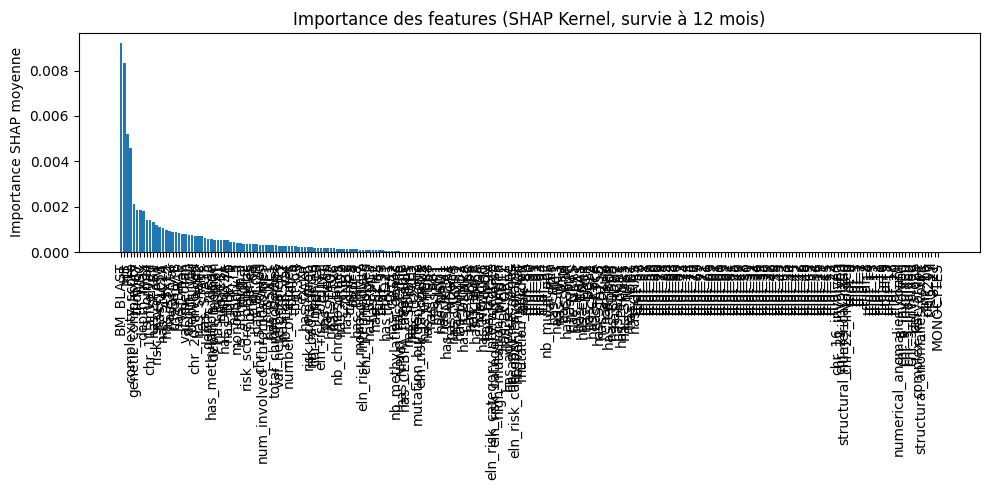

In [24]:
import torch
import shap
import numpy as np
import matplotlib.pyplot as plt

# ⚙️ Paramètres
T_max = 60
n_intervals = 41
t_target = 12

time_grid = np.linspace(0, T_max, n_intervals)
time_idx = np.argmin(np.abs(time_grid - t_target))

print(f"Temps cible {t_target} → intervalle index {time_idx} (≈ {time_grid[time_idx]:.1f})")

background_np = X_features.iloc[:100].values
test_sample_np = X_features.iloc[100:120].values
features = np.array(X_features.columns)

model.eval()

# Fonction prédictive pour SHAP : proba de survie à t_target
def predict_fn(x_numpy):
    x_torch = torch.tensor(x_numpy, dtype=torch.float32)
    with torch.no_grad():
        logits = model(x_torch)  # (batch_size, n_intervals)
        surv = mtlr_survival(logits)  # (batch_size, n_intervals), valeurs entre 0 et 1
        y_target = surv[:, time_idx].numpy()  # proba de survie à t_target
    return y_target

explainer = shap.KernelExplainer(predict_fn, background_np)

# Valeurs SHAP
shap_values = explainer.shap_values(test_sample_np, nsamples=100)

feature_importance = np.mean(np.abs(shap_values), axis=0)
sorted_idx = np.argsort(feature_importance)[::-1]

plt.figure(figsize=(10, 5))
plt.bar(features[sorted_idx], feature_importance[sorted_idx])
plt.xticks(rotation=90)
plt.title(f"Importance des features (SHAP Kernel, survie à {t_target} mois)")
plt.ylabel("Importance SHAP moyenne")
plt.tight_layout()
plt.show()

In [25]:
import pandas as pd

# Création du tableau d'importance trié
shap_df = pd.DataFrame({
    "feature": features[sorted_idx],
    "importance": feature_importance[sorted_idx]
}).reset_index(drop=True)

# Affichage markdown pour LLM
print("\nTableau markdown pour LLM :\n")
print(shap_df.to_markdown(index=False))


Tableau markdown pour LLM :

| feature                        |   importance |
|:-------------------------------|-------------:|
| BM_BLAST                       |  0.00920469  |
| HB                             |  0.0083339   |
| PLT                            |  0.00521865  |
| complexity_score               |  0.00458192  |
| genetic_complexity             |  0.00213011  |
| tfidf_67                       |  0.00186794  |
| WBC                            |  0.00186487  |
| depth_max                      |  0.00178917  |
| is_normal                      |  0.00140275  |
| chr_11_involved                |  0.00140031  |
| has_SF3B1                      |  0.00132728  |
| risk_score_raw                 |  0.00119719  |
| has_TP53                       |  0.00112187  |
| has_SMC1A                      |  0.00107861  |
| has_ASXL2                      |  0.000979784 |
| has_TET2                       |  0.000928693 |
| vaf_var                        |  0.00089599  |
| trisomy_8         